In [1]:
# if pip install isnt working:
# !python --version

# !curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py
# !python get-pip.py

# Add at the top of your notebook
def log_data_flow(stage, data_name, data):
    """Simple utility to log data flow through the pipeline"""
    if data is None:
        print(f"[DATA FLOW] {stage}: {data_name} is None")
    elif hasattr(data, 'shape'):
        print(f"[DATA FLOW] {stage}: {data_name} shape is {data.shape}")
    elif hasattr(data, '__len__'):
        print(f"[DATA FLOW] {stage}: {data_name} length is {len(data)}")
    else:
        print(f"[DATA FLOW] {stage}: {data_name} type is {type(data)}")


add citations to functions!

In [ ]:
# requirements:
#!python -m 
! pip install pandas yfinance requests numpy matplotlib PyWavelets seaborn scikit-learn scipy statsmodels tensorflow tqdm ipywidgets boruta
# import the necessary libraries.
import requests
import pywt
import os
import time
import warnings
import sys

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from datetime import datetime
from pathlib import Path
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import seaborn as sns
from joblib import Parallel, delayed
    
from boruta import BorutaPy
from statsmodels.robust import mad
from tqdm.notebook import tqdm  # For Jupyter Notebooks

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.metrics import r2_score as r2_score_func
from sklearn.base import clone
from sklearn.multioutput import MultiOutputRegressor

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, LayerNormalization, MultiHeadAttention, Add, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Partly due to unavailability of a suitable dataset that the specific use case of this project, the case study this project was designed around created their own dataset by using the yfinance (yahoo finance) library to get the stock market and bitcoin data required for this project. In future I would like to include more varied sources data sources such as those from Tiingo, to fall more in line with the case study.

To start with we'll define a directory for the datasets.csv that will need to be generated.

In [3]:
project_root = Path(os.getcwd()) # find file path of the working directory for notebook scripts.
output_dir = project_root / "dataset"
# check to see if the directory exists, make it if it doesn't
output_dir.mkdir(parents=True, exist_ok=True)

# create two additional directories, for chart outputs.
data_visualizations = project_root / "dataset" / "charts" / "data_visualizations"
denoising = project_root / "dataset" / "charts" / "denoising"
evaluation_metrics = project_root / "dataset" / "charts" / "evaluation_metrics"

data_visualizations.mkdir(parents=True, exist_ok=True)
denoising.mkdir(parents=True, exist_ok=True)
evaluation_metrics.mkdir(parents=True, exist_ok=True)

# define output path for csv files.
output_path = output_dir / "2015-2025_dataset.csv"

# defining the date range for the dataset.
start_date = "2015-01-01"
end_date = "2025-02-01"

date_range = pd.date_range(start=start_date, end=end_date, freq='D') # Format: YYYY-MM-DD, "freq" is the frequency of dates in this case: ='D' means daily.

# create data frame
df = pd.DataFrame(index=date_range)

we'll need to define a few functions that are needed before we can generate the completed dataset. Using the yahoo finance API, this block pulls the historical trading data needed for each individual major global stock exhange for volume and closed price, then converted the currencies to USD using forex data (also from the yfinance API) and returns the results. 

With some minor assistance from Claude sonnet 3.5 (Claude, 2025)

In [4]:
def fetch_stock_data(symbol: str, currency: str, start_date: str, end_date: str) -> pd.DataFrame: # (Claude, 2025)
    # yf.download is the synax for yfinance to pull data directly through python, "symbol" for the kind of data, be it a currency or a company name etc. (Documentation for the API can be found here: https://yfinance-python.org/) 
    df = yf.download(symbol, start=start_date, end=end_date)
    if df.empty:
        return pd.DataFrame(index=date_range)
        
    # Create a new DataFrame with just Close and Volume
    result = pd.DataFrame(index=df.index)
    result['Close'] = df['Close']
    result['Volume'] = df['Volume']
    
    # Get currency conversion rate if needed
    if currency:
        fx_data = yf.download(currency, start=start_date, end=end_date)
        if not fx_data.empty:
            fx_rate = fx_data['Close']
            
            # Ensure both dataframes have datetime index
            result.index = pd.to_datetime(result.index)
            fx_rate.index = pd.to_datetime(fx_rate.index)
            
            # Find common dates between stock and forex data
            common_dates = result.index.intersection(fx_rate.index)            
            # Keep only dates where we have both stock and forex data
            result = result.loc[common_dates]
            fx_rate = fx_rate.loc[common_dates]
            
            # Convert only Close prices to USD using element-wise multiplication
            result['Close'] = result['Close'].values * fx_rate.values
        else:
            return pd.DataFrame(index=date_range)
    
    # Handle volume based on the index
    if symbol in ['^N225', '^HSI']:  # Asian markets often have lower nominal volumes
        result['Volume'] = result['Volume'] / 1_000  # Convert to thousands
    else:
        result['Volume'] = result['Volume'] / 1_000_000  # Convert to millions
                
    # Add sanity checks for extreme values
    if result['Close'].max() > 50000 or result['Close'].min() < 1:
        return pd.DataFrame(index=date_range)
        
    if result['Volume'].min() == 0 or result['Volume'].max() / result['Volume'].min() > 1000:
        return pd.DataFrame(index=date_range)
        
    # Rename columns with symbol prefix
    result = result.rename(columns={
        'Close': f'{symbol}_Close_USD',
        'Volume': f'{symbol}_Volume_M'  # M for millions or thousands for Asian markets
    })
    
    # Reindex to full date range without filling
    result = result.reindex(date_range)
    return result

This function iteratively passes the "symbol" required to pull the seven stock market historical data that was chosen for inclusion in the dataset. After aquiring the entire daily closed USD price and volume data for each exchange, the data is then averaged together into two combined columns for the previously specified time frame.

- "(Tang et al.) demonstrates strong correlations between global market indices and crypto markets" 
- "The inclusion of Asian markets (Nikkei, Hang Seng) is particularly relevant as studies have shown significant Bitcoin trading volume from these regions" 
- "The SKEW index; research shows its effectiveness in predicting "black swan" events in crypto markets, OVX (Oil Volatility) "Enhancing Bitcoin Price Prediction with Deep Learning" shows volatility indices are key predictors"

- ""Cryptocurrency Valuation: An Explainable AI Approach" validates the use of on-chain metrics as fundamental indicators" - "Hash rate and mining difficulty are particularly important as they reflect network security and mining economics"
- "Transaction metrics provide insight into network usage and adoption"

- "Deep Learning for Financial Applications: A Survey" supports the inclusion of traditional safe-haven assets like gold, The DXY (Dollar Index) inclusion is supported by research showing strong inverse correlations with Bitcoin during certain market conditions"

In [5]:
def get_market_stock_data(start_date, end_date): # Some minor logical assistance from Claude AI was used her for yfinance AI syntax. (Claude, 2025)
    # date range and data frame: 
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    result_df = pd.DataFrame(index=date_range)
    
    # Define indices of each market symbol with corresponding currency symbol.
    indices = {
        'GDAXI': {'symbol': '^GDAXI', 'currency': 'EURUSD=X'},    # Germany DAX
        'IXIC': {'symbol': '^IXIC', 'currency': None},            # NASDAQ (already in USD)
        'DJI': {'symbol': '^DJI', 'currency': None},              # Dow Jones (already in USD)
        'N225': {'symbol': '^N225', 'currency': 'JPYUSD=X'},      # Nikkei
        'STOXX50E': {'symbol': '^STOXX', 'currency': 'EURUSD=X'}, # Euro STOXX 50
        'HSI': {'symbol': '^HSI', 'currency': 'HKDUSD=X'},        # Hang Seng
        'FTSE': {'symbol': '^FTSE', 'currency': 'GBPUSD=X'}       # FTSE 100
    }
    
    # Define a second data frame for later
    combined_df = pd.DataFrame(index=date_range)
    
    for index_name, info in indices.items():
        index_data = fetch_stock_data(info['symbol'], info['currency'], start_date, end_date)
        if not index_data.empty and len(index_data.columns) > 0:
            combined_df = pd.concat([combined_df, index_data], axis=1)
    
    # Collect only the columns we need for the dataset.
    close_cols = [col for col in combined_df.columns if str(col).endswith('_Close_USD')]
    volume_cols = [col for col in combined_df.columns if str(col).endswith('_Volume_M')]
    
    # Perform the mean average calculations on the columns.
    if close_cols and volume_cols:
        result_df = pd.DataFrame(index=date_range)
        result_df['Global averaged stocks(USD)'] = combined_df[close_cols].mean(axis=1, skipna=True)
        result_df['Global averaged stocks (volume)'] = combined_df[volume_cols].mean(axis=1, skipna=True)
        
        return result_df
    return pd.DataFrame(index=date_range, columns=['Global averaged stocks(USD)', 'Global averaged stocks (volume)'])

This next function works similar to the previous, collecting the US Dollar index (DXY) and the gold futures data from Yahoo Finance. Along with the Bitcoin-USD paring with its respective volume data.

In [6]:
def get_currency_metrics(start_date, end_date):  
    
    # Another new dataframe
    result_df = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date, freq='D'))
    
    # Collect the DXY (US Dollar Index) historical data.
    dxy = yf.download("DX-Y.NYB", start=start_date, end=end_date)
    result_df['Currency US Dollar Index'] = dxy['Close']
    
    # Collect the Gold Futures historical data.
    gold = yf.download("GC=F", start=start_date, end=end_date)
    result_df['Currency Gold Futures'] = gold['Close']
    
    # Collect the Bitcoin price historical data.
    btc = yf.download("BTC-USD", start=start_date, end=end_date)
    result_df['BTC/USD'] = btc['Close']
    
    # Collect the Bitcoin volume historical data.
    btc = yf.download("BTC-USD", start=start_date, end=end_date)
    result_df['BTC Volume'] = btc['Volume']
    
    # Figure out the Gold/BTC ratio buy using already collected data, where BTC price is not zero or null.
    result_df['Gold/BTC Ratio'] = result_df['Currency Gold Futures'].div(result_df['BTC/USD'].replace(0, float('nan')))
    result_df['Gold/BTC Ratio'] = result_df['Gold/BTC Ratio']
    
    return result_df

Same again here, with some additional assistence from Claude AI for the fiddly API syntax (Claude, 2025), and using the blockchain.info API, this function collects the individual "on chain" metrics.

In [7]:
def get_blockchain_metric(metric_name, start_date, end_date): # (Claude, 2025)
    
    # Fetch single blockchain metric one by one, from the Blockchain.info API.
 
    # Convert dates to timestamps
    start_ts = int(datetime.strptime(start_date, "%Y-%m-%d").timestamp())
    end_ts = int(datetime.strptime(end_date, "%Y-%m-%d").timestamp())
    
    # Fetch data from API with updated URL structure
    url = f"{"https://api.blockchain.info"}/{metric_name}"
    params = {
        "timespan": "all",
        "start": start_ts,
        "end": end_ts,
        "format": "json",
        "sampled": "true"
    }
    
    response = requests.get(url, params=params)
    if response.status_code != 200:
        return pd.Series(index=pd.date_range(start=start_date, end=end_date, freq='D'))
        
    data = response.json()
    
    # Check if the response has the expected structure
    if not isinstance(data, dict) or 'values' not in data:
        return pd.Series(index=pd.date_range(start=start_date, end=end_date, freq='D'))
    
    # Process the values
    values = []
    timestamps = []
    for entry in data['values']:
        if isinstance(entry, (list, tuple)) and len(entry) >= 2:
            timestamps.append(entry[0])
            values.append(float(entry[1]))
        elif isinstance(entry, dict) and 'x' in entry and 'y' in entry:
            timestamps.append(entry['x'])
            values.append(float(entry['y']))
    
    if not values:
        return pd.Series(index=pd.date_range(start=start_date, end=end_date, freq='D'))
    
    # Create DataFrame and handle data types
    df = pd.DataFrame({'timestamp': timestamps, 'value': values})
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s').dt.normalize()
    df = df.drop_duplicates('timestamp', keep='last')
    df.set_index('timestamp', inplace=True)
    
    # Handle potential overflow for large numbers
    df['value'] = df['value'].astype('float64')
    
    # Reindex to ensure consistent date range
    return df['value'].reindex(date_range)

This function calls the previous block iteratively for each metric of "on chain" data, with some minor assistence from Caude AI for syntax errors. (Claude, 2025)

In [8]:
def get_onchain_metrics(start_date, end_date): # (Claude, 2025)
    result_df = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date, freq='D'))
    # Define metrics and their API endpoints with updated paths
    metrics = {
        'Onchain Active Addresses': 'charts/n-unique-addresses',
        'Onchain Transaction Count': 'charts/n-transactions',
        'Onchain Hash Rate (GH/s)': 'charts/hash-rate',
        'Onchain Mining Difficulty': 'charts/difficulty',
        'Onchain Transaction Fees (BTC)': 'charts/transaction-fees',
        'Onchain Median Confirmation Time (min)': 'charts/median-confirmation-time'
    }
    
    # Fetch each metric
    for col_name, metric_name in metrics.items():
        series = get_blockchain_metric(metric_name, start_date, end_date)
        result_df[col_name] = series
        
        # Handle missing values for each metric appropriately
        if col_name in ['Onchain Mining Difficulty', 'Onchain Hash Rate (GH/s)']:
            result_df[col_name] = result_df[col_name]
        elif col_name in ['Onchain Transaction Count', 'Onchain Active Addresses']:
            result_df[col_name] = result_df[col_name]
        else:
            result_df[col_name] = result_df[col_name]
    
    return result_df

These additional metrics track the volatility of the S&P500 stock market and the crude oil volatility index.

In [9]:
def get_volatility_indices(start_date, end_date):    
    df = pd.DataFrame()
    
    # Collect the CBOE SKEW index from Yahoo Finance
    skew = yf.download("^SKEW", start=start_date, end=end_date)
    df['Volatility_CBOE SKEW Index'] = skew['Close']
    
    # Collect the VIX index from Yahoo Finance 
    vix = yf.download("^VIX", start=start_date, end=end_date)
    df['Volatility_CBOE Volatility Index (VIX)'] = vix['Close']
    
    # Collect the Oil VIX index from Yahoo Finance 
    ovx = yf.download("^OVX", start=start_date, end=end_date)
    df['Volatility_Crude Oil Volatility Index (OVX)'] = ovx['Close']
    
    return df

https://medium.com/@100trillionUSD/modeling-bitcoins-value-with-scarcity-91fa0fc03e25

https://medium.com/@100trillionUSD/bitcoin-stock-to-flow-cross-asset-model-50d260feed12

https://newhedge.io/bitcoin/stock-to-flow

Here we includ and calculate the "Stock to Flow" model intially conceptualized by "PlanB".

Largely assisted by Claude AI for the math and syntax (Claude, 2025).

In [10]:
def calculate_stock_to_flow(start_date, end_date): # (Claude, 2025)
    
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    s2f_df = pd.DataFrame(index=date_range)
    
    # API parameters
    params = {
        "timespan": "all",
        "start": int(pd.Timestamp(start_date).timestamp()),
        "end": int(pd.Timestamp(end_date).timestamp()),
        "format": "json",
        "sampled": "false"
    }
    
    # Get total supply
    response = requests.get("https://api.blockchain.info/charts/total-bitcoins", params=params)
    if response.status_code == 200:
        data = response.json()['values']
        df = pd.DataFrame(data, columns=['x', 'y'])
        df['timestamp'] = pd.to_datetime(df['x'], unit='s').dt.normalize()
        stock = df.groupby('timestamp')['y'].mean()
        stock = stock.reindex(date_range).interpolate(method='linear')
        
        # Calculate flow based on Bitcoin halving schedule
        s2f_df['timestamp'] = date_range
        s2f_df['block height'] = ((s2f_df['timestamp'] - pd.Timestamp('2009-01-03')) / pd.Timedelta(minutes=10)).astype(int) # "genesis block" date (January 3, 2009) the first BTC block to be mined.
        
        # Calculate daily block rewards based on halving schedule
        def get_block_reward(block_height):
            halvings = block_height // 210000 # Roughly every 4 years there is a BTC "halving event" (when the mining rewards are halved) this is every 210,000 blocks.
            return 50 / (2 ** halvings)
        
        s2f_df['daily production'] = s2f_df['block height'].apply(get_block_reward) * 144  # Timing by 144 gives us the total daily Bitcoin production (24 hours * 60 minutes) / 10 minutes = 144 blocks per day, ".apply(get_block_reward)" calculates the reward for each block height.
        
        # Calculate S2F ratio (stock divided by yearly flow)
        s2f_df['s2f ratio'] = stock / (s2f_df['daily production'] * 365)
        
        # Calculate expected price using S2F model
        # Using the formula: Price = exp(-1.84) * S2F^3.36
        s2f_df['S2F Model'] = np.exp(-1.84) * (s2f_df['s2f ratio'] ** 3.36)
        
        # Convert to USD and handle any extreme values
        s2f_df['S2F Model'] = s2f_df['S2F Model']
        
        return s2f_df[['S2F Model']]
    
    return pd.DataFrame(index=date_range)

Main fuction for compiling, saving and ordering all the columns required for this dataset.

In [ ]:
# Collect all the data from the functions we created earlier, into the tuple list.
tuple_list = [
    ('Stockmarket', get_market_stock_data(start_date, end_date)),
    ('Currency Metrics', get_currency_metrics(start_date, end_date)),
    ('On-chain Metrics', get_onchain_metrics(start_date, end_date)),
    ('Volatility Indices', get_volatility_indices(start_date, end_date)),
    ('S2F Model', calculate_stock_to_flow(start_date, end_date))
    ]

# Combine all the data check for empty columns.
for name, tuple_df in tuple_list:
    if tuple_df is not None and not tuple_df.empty:
        for column in tuple_df.columns:
            df[column] = tuple_df[column]

# Reorder the columns, group related metrics together.
column_order = [
    'Global averaged stocks(USD)',
    'Global averaged stocks (volume)',
    'Currency US Dollar Index',
    'Currency Gold Futures',
    'Volatility_CBOE SKEW Index',
    'Volatility_CBOE Volatility Index (VIX)',
    'Volatility_Crude Oil Volatility Index (OVX)',
    'Gold/BTC Ratio',
    'BTC/USD',
    'BTC Volume',
    'S2F Model',
    'Onchain Active Addresses',
    'Onchain Transaction Count',
    'Onchain Hash Rate (GH/s)',
    'Onchain Mining Difficulty',
    'Onchain Transaction Fees (BTC)',
    'Onchain Median Confirmation Time (min)'
]

# Reorder the columns
df = df[column_order]

# Save the dataset
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path)
print(f"Dataset saved to {output_path}")
print(f"Shape: {df.shape}")

"Shape: (3685, 17)" tells us that we have collected all the required columns for the dataset. We should have a dataset that is largly complete, except for missing entries in the weekends for stockmarket data as trading closes on the weekends, unlike crypto which trades 24/7. We can easily view missing data in the CSV file by using "print("missing data by column:")" and "print(df.isna().sum())". 

Additionally since we are using financial sequencial data (or time series forecasting) for the models we'll be training, duplicate data is generally less of a concern however its good practice to verify the quality and integrity of the dataset regardless and the unique entries with "df.unique()" (then view "df.head()" to see the first five values in the dataset).

In [ ]:
df = pd.read_csv(output_path, index_col=0, parse_dates=True)

# Print data by by column
print("missing data by column: ")
print(df.isna().sum(), "\n")

# Print duplicates by column
print("duplicates by column: ")
print(df.duplicated(subset=None, keep='first').sum())

print("\nduplicates: ")
print(df[df.duplicated(keep='first')])

#Print unique values by column
print("\nunique: ")
print(df.nunique())

# display first five entries
df.head()

It appears the "on chain metrics" are also missing data (every other day), it is here that we begin the process of "cleaning" the data, we'll start by remedying the missing entries with linear interpolation. This creating a smooth transition of values between the missing data in the dataset, crusially preserving the original data's time series characteristics. 

We would otherwise lose fidelity if the sequence of entries were to become incorrectly scaled by dropping empty rows, or unintentionally added new characteristics to the data by using averages to fill the empty rows. Using backward or forward fill would also be sub optimal as it duplicates values creating unrepresentative square wave patterns not typical of financial market data.

In [ ]:
# Load the saved dataset
df = pd.read_csv(output_path, index_col=0, parse_dates=True)

# Interpolate each column based on its data type
for column in df.columns:
    # For all other metrics (prices, volumes, etc), use linear interpolation
    df[column] = df[column].interpolate(method='linear', limit=5)

# Save the interpolated dataset with a new name
interpolated_path = output_dir / "2015-2025_dataset_interpolated.csv"
df.to_csv(interpolated_path)

print(f"\nInterpolated dataset saved to {interpolated_path}")
print(f"Shape: {df.shape}")

# display first five entries, validation.
df.head()

The next important step is to process the data, we'll need to normalize it making it more machine readable and comparable between columns. We will also re run the interp to attempt to fill the missing values in the first row.

In [ ]:
df = pd.read_csv(output_dir / "2015-2025_dataset_interpolated.csv", index_col=0, parse_dates=True)

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Create a copy of the dataframe and normalize all columns
df_normalized = pd.DataFrame(
    scaler.fit_transform(df),
    columns=df.columns,
    index=df.index
)

# Save as new
df_normalized.to_csv(output_dir / "2015-2025_dataset_normalized.csv")

# display first five entries, validation.
df_normalized.head()

df = pd.read_csv(output_dir / "2015-2025_dataset_normalized.csv", index_col=0, parse_dates=True)

# Interpolate each column based on its data type
for column in df.columns:
    # For all other metrics (prices, volumes, etc), use linear interpolation
    df[column] = df[column].interpolate(method='linear', limit=20, limit_direction='backward')


# Save the interpolated dataset with a new name
df_re_norm = output_dir / "2015-2025_dataset_normalized.csv"

df.to_csv(df_re_norm)

print(f"\nInterpolated dataset saved to {interpolated_path}")
print(f"Shape: {df.shape}")

# display first five entries, validation.
df.head()


Unfortunately there are still missing values in "on chain mining dificulty" so we'll resort to back and farward filling any remaining missing values with "bfill() and .ffill()".

In [ ]:
df = pd.read_csv(output_dir / "2015-2025_dataset_normalized.csv", index_col=0, parse_dates=True)
df = df.bfill().ffill() # back and forward fill.

df_save = output_dir / "2015-2025_dataset_normalized.csv"

# save the data frame.
df.to_csv(df_save)

# validate
df.head()

This is where we move onto the data visualization section, with some further assistence from Claude AI the graph plotting for the majority of the data visualizations were organized into functions for reuseability, readability and maintainability. (Claude, 2025)

In [16]:
# Common plotting function for time series visualization
def plot_time_series(df, title, ax, color='blue', alpha=0.8, linewidth=1.5): # (Claude, 2025)
    """
    Reusable function to plot time series data with consistent styling
    """
    # Plot the time series
    ax.plot(df.index, df, color=color, alpha=alpha, linewidth=linewidth)
    
    # Set title and labels
    ax.set_title(title, fontsize=11)
    ax.set_ylabel('Value', fontsize=9)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Explicitly set x-axis limits to ensure full timeline is used
    ax.set_xlim(df.index.min(), df.index.max())
    
    return ax

def format_time_axis(ax, is_last=False): # (Claude, 2025)
    """
    Reusable function to format time axis with consistent styling
    """
    if not is_last:
        ax.set_xlabel('')
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.set_xlabel('Date', fontsize=10)
        # Set fewer x-ticks for better readability
        locator = mdates.YearLocator()  # Show only years
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        
        # Add minor ticks for quarters without labels
        minor_locator = mdates.MonthLocator(bymonth=[1, 4, 7, 10])
        ax.xaxis.set_minor_locator(minor_locator)
        
        # Rotate labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

In [17]:
def plot_time_series_comparison(x, y1, y2, title, ax, labels=None): # (Claude, 2025)
    if labels is None:
        labels = ['Series 1', 'Series 2']
    
    ax.plot(x, y1, color='#1f77b4', linewidth=1.5, label=labels[0])
    ax.plot(x, y2, color='#ff7f0e', linewidth=1.5, linestyle='--', label=labels[1])
    
    ax.set_title(title, fontsize=11)
    ax.set_xlabel('Sample Index', fontsize=9)
    ax.set_ylabel('Value', fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    return ax

In [18]:
def create_bar_plot(ax, categories, values, title, ylabel, color='skyblue', percentage=True, colors=None):
    """
    Create a bar plot with value labels
    Added colors parameter to support multiple colors for different bars
    """
    if colors is not None:
        # Use individual colors for each bar
        bars = ax.bar(categories, values, color=colors)
    else:
        # Use a single color for all bars
        bars = ax.bar(categories, values, color=color)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        if percentage:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.2%}', ha='center', va='bottom', fontsize=9)
        else:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)
    
    ax.set_title(title, fontsize=11)
    ax.set_ylabel(ylabel, fontsize=9)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    return ax

In [19]:
def create_bar_plot(ax, categories, values, title, ylabel, color='skyblue', percentage=True, colors=None, ylim=None, add_context_bands=False, metric_type=None):
    # Set fixed y-axis limits if provided
    if ylim is not None:
        ax.set_ylim(ylim)
    
    # Add context bands for specific metrics
    if add_context_bands and metric_type == 'mase':
        # Add interpretation bands for MASE
        ax.axhspan(0, 1, alpha=0.2, color='green', label='Good (MASE < 1)')
        ax.axhspan(1, 2, alpha=0.2, color='yellow', label='Fair (1 < MASE < 2)')
        if ylim and ylim[1] > 2:
            ax.axhspan(2, ylim[1], alpha=0.2, color='red', label='Poor (MASE > 2)')
        ax.legend(loc='upper right', fontsize=8)
    
    # Create the bars with appropriate colors
    if colors is not None:
        # Use individual colors for each bar
        bars = ax.bar(categories, values, color=colors)
    else:
        # Use a single color for all bars
        bars = ax.bar(categories, values, color=color)
    
    # Highlight bars with warning colors for error metrics
    if metric_type == 'error':
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if height > 1.0:  # Error > 100%
                bar.set_color('red')
    
    # Add value labels on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        
        # Format label based on percentage flag
        if percentage:
            label_text = f'{height:.2%}'
        else:
            label_text = f'{height:.4f}'
        
        # Add the label
        ax.text(bar.get_x() + bar.get_width()/2., 
                min(height + 0.01, (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95 + ax.get_ylim()[0]), 
                label_text, ha='center', va='bottom', fontsize=9)
        
        # Add interpretation for MASE
        if metric_type == 'mase':
            if height < 1:
                interpretation = "Better than naive"
            elif height < 2:
                interpretation = "Comparable to naive"
            else:
                interpretation = "Worse than naive"
                
            ax.text(bar.get_x() + bar.get_width()/2., height/2, 
                    interpretation, ha='center', va='center', 
                    fontsize=8, rotation=90, color='black')
        
        # Add warning for error metrics > 100%
        if metric_type == 'error' and height > 1.0:
            ax.text(bar.get_x() + bar.get_width()/2., height/2, 
                   "ERROR TOO HIGH", ha='center', va='center',
                   fontsize=8, rotation=90, color='white', fontweight='bold')
    
    ax.set_title(title, fontsize=11)
    ax.set_ylabel(ylabel, fontsize=9)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    return ax

This following block is largely Claude AI assisted, due to time contraints with the scale and ambition of the project, keeping data visualizations visually constistent throughout developement, while still attempting to accomplish the desired results, was proving challenging with the limited time dedicated to development. (Claude, 2025)

In [ ]:
# Read the dataset
df = pd.read_csv(output_dir / "2015-2025_dataset_normalized.csv", index_col=0, parse_dates=True)

# 1. Correlation Matrix
plt.figure(figsize=(12, 10))
sns.set(font_scale=0.8)
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, fmt=".2f", annot_kws={"size": 7})
plt.title('Correlation Matrix of Features', fontsize=16)
plt.tight_layout()
plt.savefig(output_dir / "charts" / "data_visualizations" / "correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. Missing Value Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.isna(), cmap='viridis', cbar_kws={'label': 'Missing Values'})
plt.title('Missing Values Heatmap', fontsize=16)
plt.tight_layout()
plt.savefig(output_dir / "charts" / "data_visualizations" / "missing_values_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. Distribution and Outliers - Box and Violin Plots
n_cols = len(df.columns)
n_rows = (n_cols + 2) // 3  # Arrange in rows of 3 plots

fig = plt.figure(figsize=(18, n_rows * 5))
gs = GridSpec(n_rows, 3, figure=fig)

for i, column in enumerate(df.columns):
    row, col = divmod(i, 3)
    ax = fig.add_subplot(gs[row, col])
    
    # Fix the warning by using color instead of palette
    sns.violinplot(y=df[column], ax=ax, inner='box', color='skyblue')
    ax.set_title(f'Distribution of {column}', fontsize=12)
    ax.set_ylabel('Value')
    
    # Add scatter points for outliers
    outliers = df[abs(df[column] - df[column].mean()) > (3 * df[column].std())]
    if not outliers.empty:
        sns.stripplot(y=outliers[column], ax=ax, color='red', size=4, jitter=True)

plt.tight_layout()
plt.savefig(output_dir / "charts" / "data_visualizations" / "distribution_outliers.png", dpi=300, bbox_inches='tight')
plt.show()

# 4. Time Series Plots - Using the common functions
fig, axes = plt.subplots(n_cols, 1, figsize=(15, n_cols * 2.5), sharex=True)

# Handle case where there's only one column
if n_cols == 1:
    axes = [axes]

for i, column in enumerate(df.columns):
    # Use the common plot_time_series function
    plot_time_series(df[column], f'Time Series: {column}', axes[i], 
                    color='#1f77b4', alpha=0.8, linewidth=1.5)
    
    # Use the common format_time_axis function
    format_time_axis(axes[i], is_last=(i == n_cols-1))

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.3)

# Use tight_layout with appropriate padding
plt.tight_layout(pad=1.2)
plt.savefig(output_dir / "charts" / "data_visualizations" / "time_series.png", dpi=300, bbox_inches='tight')
plt.show()

# 5. BONUS: Combined Pairplot for selected features
if n_cols <= 10:  # Only do this if you have a reasonable number of columns
    plt.figure(figsize=(20, 20))
    sns.pairplot(df, diag_kind='kde', plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'k'})
    plt.suptitle('Pairwise Relationships Between Features', y=1.02, fontsize=20)
    plt.tight_layout()
    plt.savefig(output_dir / "charts" / "data_visualizations" / "pairplot.png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    # If too many columns, select a subset based on correlation
    # Get the most correlated features
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
    
    # Keep correlated features and a few others
    important_cols = list(set(df.columns) - set(to_drop))
    if len(important_cols) > 8:
        important_cols = important_cols[:8]
    
    plt.figure(figsize=(20, 20))
    sns.pairplot(df[important_cols], diag_kind='kde', 
                plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'k'})
    plt.suptitle('Pairwise Relationships Between Key Features', y=1.02, fontsize=20)
    plt.tight_layout()
    plt.savefig(output_dir / "charts" / "data_visualizations" / "pairplot_selected.png", dpi=300, bbox_inches='tight')
    plt.show()

Instead of handling outliers by averaging or removing them, the choise was made to follow this case studies method of outlier handling instead (Gil et al., 2024) by utilizing "multiresolution wavelet reconstruction" or "denoising" on the dataset, the specific mathematical formula for this was not detailed in the case study followed however but was "inspired" or rather a modified techneque referenced from a different paper (Peng et al., 2021). For this project the later was chosen due to its more detailed descripting making it easier to replicated more accurately.

The following denoising code was block was largely assisted by deepseek-r1, based on (Peng et al., 2021)'s paper. (Deepseek-r1, 2025)

In [21]:
# Wavelet denoising function
def wavelet_denoising(df, wavelet='db4', level=3): # (Deepseek-r1, 2025)
    """
    Apply wavelet denoising to all columns in a DataFrame
    """
    df_denoised = df.copy()
    
    for column in df.columns:
        # 1. Multi-level decomposition
        coeffs = pywt.wavedec(df[column].values, wavelet, level=level)
        
        # 2. Calculate noise threshold
        sigma = mad(coeffs[-1])
        n = len(df[column])
        threshold = sigma * np.sqrt(2 * np.log(n)) * 0.8  # Conservative thresholding
        
        # 3. Apply soft thresholding
        coeffs_modified = [coeffs[0]]
        for i in range(1, len(coeffs)):
            coeffs_modified.append(pywt.threshold(coeffs[i], threshold, 'soft'))
        
        # 4. Reconstruct signal
        denoised_data = pywt.waverec(coeffs_modified, wavelet)
        
        # 5. Handle boundary effects
        if len(denoised_data) > len(df):
            denoised_data = denoised_data[:len(df)]
        elif len(denoised_data) < len(df):
            denoised_data = np.pad(denoised_data, (0, len(df)-len(denoised_data)), 'edge')
            
        df_denoised[column] = denoised_data
    
    return df_denoised

Plotting the results of the denoised data side by side with showing the noise data that wasremoved from the dataset. According to (Gil et al., 2024) the denoised data maintains many of its price structure characterists without as much "radnomness" or minor price action that would otherwise only serve to confuse the model.

In [ ]:
def plot_denoising_results(original_data, denoised_data, column_name): # (Claude, 2025)
    """
    Plot denoising results with consistent styling matching the time series plots
    """
    noise = original_data[column_name] - denoised_data[column_name]
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
    
    # Original and denoised data
    plot_time_series(original_data[column_name], f'Denoising Results for {column_name}', 
                    axes[0], color='#1f77b4', alpha=0.5, linewidth=1.5)
    plot_time_series(denoised_data[column_name], None, 
                    axes[0], color='#ff7f0e', alpha=0.8, linewidth=1.5)
    axes[0].legend(['Original', 'Denoised'], loc='upper right', fontsize=9)
    
    # Removed noise
    plot_time_series(noise, 'Removed Noise Component', 
                    axes[1], color='#d62728', alpha=0.5, linewidth=1)
    
    # Format time axis
    format_time_axis(axes[0], is_last=False)
    format_time_axis(axes[1], is_last=True)
    
    # Adjust spacing
    plt.subplots_adjust(hspace=0.2)
    plt.tight_layout(pad=1.2)
    
    return fig

# Print summary statistics
print("Dataset Summary Statistics:")
print(df.describe())

# Print missing value counts
print("\nMissing Values Count:")
print(df.isna().sum())
print(f"Total missing values: {df.isna().sum().sum()}")

In [ ]:
def plot_all_denoised_columns(original_df, denoised_df): # (Claude, 2025)
    """
    Plot all columns in a single figure with consistent styling,
    including noise charts underneath each time series
    """
    n_cols = len(original_df.columns)
    # Create twice as many rows - one for the signal, one for the noise
    fig, axes = plt.subplots(n_cols * 2, 1, figsize=(15, n_cols * 4), sharex=True)
    
    # Handle case where there's only one column
    if n_cols == 1:
        axes = np.array([axes[0], axes[1]])
    
    for i, column in enumerate(original_df.columns):
        # Calculate the noise component
        noise = original_df[column] - denoised_df[column]
        
        # Index for the signal plot
        signal_idx = i * 2
        # Index for the noise plot
        noise_idx = i * 2 + 1
        
        # Plot original and denoised data on the signal plot
        plot_time_series(original_df[column], f'Time Series: {column}', 
                        axes[signal_idx], color='#1f77b4', alpha=0.5, linewidth=1.5)
        plot_time_series(denoised_df[column], None, 
                        axes[signal_idx], color='#ff7f0e', alpha=0.8, linewidth=1.5)
        axes[signal_idx].legend(['Original', 'Denoised'], loc='upper right', fontsize=8)
        
        # Plot noise component on the noise plot
        plot_time_series(noise, f'Noise Component: {column}', 
                        axes[noise_idx], color='#d62728', alpha=0.7, linewidth=1)
        
        # Format time axes
        format_time_axis(axes[signal_idx], is_last=False)
        format_time_axis(axes[noise_idx], is_last=(i == n_cols-1 and noise_idx == (n_cols*2)-1))
        
    # Filter out NaN and Inf values before calculating statistics
    valid_noise = noise.replace([np.inf, -np.inf], np.nan).dropna()
    
    if len(valid_noise) > 0:
        noise_std = valid_noise.std()
        noise_mean = valid_noise.mean()
        
        # Check if the calculated values are finite
        if np.isfinite(noise_std) and np.isfinite(noise_mean) and noise_std > 0:
            axes[noise_idx].set_ylim([noise_mean - 3*noise_std, noise_mean + 3*noise_std])
        else:
            # Use default limits if statistics are not valid
            axes[noise_idx].set_ylim([-1, 1])
    else:
        # Use default limits if no valid data
        axes[noise_idx].set_ylim([-1, 1])
    
    # Adjust spacing
    plt.subplots_adjust(hspace=0.3)
    plt.tight_layout(pad=1.2)
    
    return fig

# Main execution code
df = pd.read_csv(output_dir / "2015-2025_dataset_normalized.csv", index_col=0, parse_dates=True)

# Apply wavelet denoising
df_denoised = wavelet_denoising(df)

# Plot individual denoising results for each column
for column in df.columns:
    fig = plot_denoising_results(df, df_denoised, column)
    plt.savefig(output_dir / "charts" / "denoising" /  f"denoising_{column.replace('/', '_')}.png", dpi=300, bbox_inches='tight')
    plt.close(fig)

# Plot all columns in a single figure with noise charts
fig = plot_all_denoised_columns(df, df_denoised)
plt.savefig(output_dir / "charts" / "denoising" /  "all_denoised_columns_with_noise.png", dpi=300, bbox_inches='tight')
plt.show()

# Save the denoised dataset
df_denoised.to_csv(output_dir / "2015-2025_dataset_denoised.csv")
print(f"Denoised dataset saved to {output_dir / '2015-2025_dataset_denoised.csv'}")

Now for feature selection:

(Ghosh et al., 2022)'s Bourta selection library.

(Tyralis & Papacharalampous, 2017)'s method - "Variable Selection in Time Series Forecasting Using Random Forests", using both his prediction and feature selection method.

LASSO feature selection method: https://www.tandfonline.com/doi/epdf/10.1080/09540091.2023.2286188?needAccess=true



The code for this section was AI assisted, along with help to understand the underlying papers solutions, methods and processes both Claude sonnet and deepseek r-1 were consulted (Claude, 2025), (Deepseek-r1, 2025).

This next specific block generates the resulting feature importance scores the algorithms used to decide on the features to be selected once called.

In [24]:
# Saving and plotting the feature selection of choice: # (Claude, 2025), (Deepseek-r1, 2025)
def load_data(filepath):
    df = pd.read_csv(filepath, index_col=0, parse_dates=True)
    return df

# Use 'Score' column consistently - AI contributed:
def plot_feature_importance(scores_df, method_name):
    plt.figure(figsize=(12, 8))
    
    # Get selected features and their scores
    selected_scores = scores_df[scores_df['Selected']]
    score_col = 'Score' if 'Score' in selected_scores.columns else 'Importance'
    
    # Create horizontal bar plot
    plt.barh(range(len(selected_scores)), selected_scores[score_col])
    plt.yticks(range(len(selected_scores)), selected_scores['Feature'])
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.title(f'Feature Importance Scores - {method_name}')
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()

def save_selected_features(df, selected_features, target, method_name, dataset_type):
    final_features = selected_features + [target]
    df_selected = df[final_features]
    output_path = output_dir / f"2015-2025_dataset_selected_features_{method_name}_{dataset_type}.csv"
    df_selected.to_csv(output_path)
    return df_selected.shape

(Tyralis & Papacharalampous, 2017)'s feature selection method:

In [25]:
def random_forest_selection(df, target='BTC/USD', window_size=30, n_estimators=500, perform_tuning=False, n_iterations=10, n_jobs=-1): # (Claude, 2025)
    print(f"\nInitializing Random Forest feature selection...")
    print(f"Input DataFrame shape: {df.shape}")
    print(f"Target column: {target}")
    print(f"Window size: {window_size}")
    
    if df.empty:
        raise ValueError("Input DataFrame is empty")
    
    start_time = time.time()
    
    X = df.drop(target, axis=1)
    y = df[target]
    
    # Store feature names for later use
    feature_names = X.columns.tolist()
    print(f"Number of features: {len(feature_names)}")
    
    # Calculate number of windows
    n_windows = len(X) - window_size
    print(f"Number of windows: {n_windows}")
    
    # Initialize importance matrix
    importance_matrix = np.zeros((n_windows, X.shape[1]))
    
    # Determine optimal RF parameters if tuning is requested
    if perform_tuning:
        print("\nPerforming Bayesian hyperparameter tuning...")
        
        # Import required libraries for Bayesian optimization
        from skopt import BayesSearchCV
        from skopt.space import Real, Integer, Categorical
        
        # Use a sample window for tuning
        sample_window = slice(0, min(window_size * 3, len(X)))
        X_sample = X.iloc[sample_window]
        y_sample = y.iloc[sample_window]
        
        # Define the hyperparameter search space
        param_space = {
            'n_estimators': Integer(10, 100),
            'max_depth': Integer(3, 20),
            'min_samples_split': Integer(2, 10),
            'min_samples_leaf': Integer(1, 5),
            'max_features': Categorical(['sqrt', 'log2', None]),
            'bootstrap': Categorical([True, False])
        }
        
        # Create base RF model
        base_rf = RandomForestRegressor(random_state=42, n_jobs=n_jobs)
        
        # Create BayesSearchCV object
        bayes_search = BayesSearchCV(
            base_rf,
            param_space,
            n_iter=n_iterations,
            cv=3,  # Use 3-fold cross-validation
            scoring='neg_mean_squared_error',
            n_jobs=n_jobs,
            verbose=1,
            random_state=42
        )
        
        # Fit the Bayesian search
        print("Starting Bayesian optimization...")
        bayes_search.fit(X_sample, y_sample)
        
        # Get the best parameters
        best_params = bayes_search.best_params_
        print(f"Best parameters found: {best_params}")
        
        # Create RF with best parameters
        rf = RandomForestRegressor(**best_params, random_state=42, n_jobs=n_jobs)
    else:
        # Use default parameters
        rf = RandomForestRegressor(
            n_estimators=n_estimators,
            max_features='sqrt',
            random_state=42,
            n_jobs=n_jobs
        )
    
    # Function to process a single window
    def process_window(i):
        # Extract window data
        window_data = X.iloc[i:i + window_size]
        window_target = y.iloc[i:i + window_size]
        
        # Fit RF on window
        rf_local = clone(rf)  # Create a clone to avoid race conditions
        rf_local.fit(window_data, window_target)
        baseline_score = rf_local.score(window_data, window_target)
        
        # Calculate feature importances
        importances = np.zeros(X.shape[1])
        
        for j in range(X.shape[1]):
            X_perm = window_data.copy()
            X_perm.iloc[:,j] = np.random.permutation(X_perm.iloc[:,j])
            perm_score = rf_local.score(X_perm, window_target)
            importances[j] = baseline_score - perm_score
        
        return importances
    
    # Process windows in parallel
    print("\nProcessing windows in parallel...")
    
    # Process windows in parallel with progress bar
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_window)(i) for i in tqdm(range(n_windows), desc="Processing windows")
    )
    
    # Combine results
    importance_matrix = np.array(results)
    
    # Calculate mean importance across windows
    mean_importances = importance_matrix.mean(axis=0)
    
    # Apply quantile threshold (75th percentile)
    threshold = np.quantile(mean_importances, 0.75)
    selected_features = [feature_names[i] for i, imp in enumerate(mean_importances) if imp > threshold]
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Feature': feature_names,
        'Score': mean_importances,
        'Selected': mean_importances > threshold
    }).sort_values('Score', ascending=False)
    
    # Print summary
    end_time = time.time()
    print(f"\nFeature selection completed in {end_time - start_time:.2f} seconds")
    print(f"Selected {len(selected_features)} out of {len(feature_names)} features")
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    
    # Sort features by importance
    sorted_idx = np.argsort(mean_importances)
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    
    plt.barh(pos, mean_importances[sorted_idx], align='center')
    plt.yticks(pos, np.array(feature_names)[sorted_idx])
    plt.xlabel('Mean Importance')
    plt.title('Feature Importances (Random Forest)')
    
    # Add a vertical line at the threshold
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold (75th percentile)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return selected_features, results_df

LASSO Method:

In [26]:
def lasso_feature_selection(df, target='BTC/USD', alpha='auto'): # (Claude, 2025)
    from sklearn.linear_model import LassoCV, Lasso
    from sklearn.preprocessing import StandardScaler
    
    # Prepare data
    X = df.drop(target, axis=1)
    y = df[target]
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Determine optimal alpha if auto
    if alpha == 'auto':
        lasso_cv = LassoCV(cv=5, random_state=42)
        lasso_cv.fit(X_scaled, y)
        alpha = lasso_cv.alpha_
    
    # Fit LASSO
    lasso = Lasso(alpha=alpha, random_state=42)
    lasso.fit(X_scaled, y)
    
    # Get selected features
    selected_features = X.columns[lasso.coef_ != 0].tolist()
    
    # Create importance scores
    importance_scores = pd.DataFrame({
        'Feature': X.columns,
        'Score': np.abs(lasso.coef_),
        'Selected': lasso.coef_ != 0
    }).sort_values('Score', ascending=False)
    
    print(f"\nSelected {len(selected_features)} features")
    print("\nTop features and weights:")
    print(importance_scores[importance_scores['Selected']].head())
    
    return selected_features, importance_scores

'"Boruta" is an "ensemble feature selection algorithm" using random forest with feature importance measures for selection, (Ghosh et al., 2022) We used the existing scikit-learn implementation of the Boruta algorithm available at https://github.com/scikit-learn-contrib/boruta_py."' (Pabuccu & Barbu, 2023).

In [27]:
def boruta_selection(df, target='BTC/USD', max_iter=100, importance_threshold=0.01): # (Claude, 2025)    
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    
    X = df.drop(target, axis=1)
    y = df[target]
    
    rf = RandomForestRegressor(
        n_jobs=-1,
        max_depth=7,
        n_estimators=250,
        random_state=42
    )
    
    boruta = BorutaPy(
        rf,
        n_estimators='auto',
        max_iter=max_iter,
        perc=98,
        alpha=0.001,
        two_step=True,
        verbose=0,
        random_state=42
    )
    
    with tqdm(total=1, desc="Running Boruta Selection") as pbar:
        boruta.fit(X.values, y.values)
        pbar.update(1)
    
    if hasattr(boruta, 'importance_history_'):
        feature_importance = boruta.importance_history_.mean(axis=0)[:X.shape[1]]
        scores = feature_importance / np.max(feature_importance)
        
        min_nonzero = np.min(feature_importance[feature_importance > 0])
        relative_scores = np.zeros_like(feature_importance)
        nonzero_mask = feature_importance > 0
        relative_scores[nonzero_mask] = 10 * (np.log1p(feature_importance[nonzero_mask]) - np.log1p(min_nonzero)) / (np.log1p(np.max(feature_importance)) - np.log1p(min_nonzero))
    else:
        scores = np.ones(len(X.columns))
        relative_scores = np.ones(len(X.columns))
        feature_importance = np.ones(len(X.columns))
    
    significant_features = scores >= importance_threshold
    
    importance_scores = pd.DataFrame({
        'Feature': X.columns,
        'Importance': scores.round(4),
        'Relative_Importance': relative_scores.round(2),
        'Raw_Score': feature_importance.round(6),
        'Selected': significant_features,
        'Score': scores.round(4)  # Add Score column for compatibility
    })
    
    importance_scores = importance_scores.sort_values('Importance', ascending=False)
    selected_features = importance_scores[importance_scores['Selected']]['Feature'].tolist()
    
    print(f"\nSelected {len(selected_features)} features")
    print("\nSelected features by importance:")
    print(importance_scores[importance_scores['Selected']].to_string(index=False))
    
    return selected_features, importance_scores

this is the function that runs all three of the automated feature selection methods:

In [28]:
def run_feature_selection(method_choice): # (Claude, 2025)
    # create two datasets
    df_denoised = pd.read_csv(output_dir / "2015-2025_dataset_denoised.csv", index_col=0, parse_dates=True)
    df_normalized = pd.read_csv(output_dir / "2015-2025_dataset_normalized.csv", index_col=0, parse_dates=True)
    
    datasets = [df_denoised, df_normalized]
    target = 'BTC/USD'
    
    methods = {
        'random_forest': {
            'func': random_forest_selection,
            'params': {'window_size': 30}
            
        },
        'lasso': {
            'func': lasso_feature_selection,
            'params': {}
        },
        'boruta': {
            'func': boruta_selection,
            'params': {}
        }
    }
    # loop through all the normalized and denoised sets 
    for df in datasets:
        # Determine dataset type for passing to save_selected_features
        dataset_type = 'denoised' if df.equals(df_denoised) else 'normalized'
        
        # Execute selected method
        if method_choice in ['random_forest', 'lasso', 'boruta']:
            selected_features, importance_scores = methods[method_choice]['func'](
                df, target, **methods[method_choice]['params']
            )
            
            # Ensure consistent column naming
            if 'Importance' in importance_scores.columns:
                importance_scores['Score'] = importance_scores['Importance']
            
            # Save results and plot
            shape = save_selected_features(df, selected_features, target, method_choice, dataset_type)
            plot_feature_importance(importance_scores, method_choice)
            
            print(f"\nSelected {len(selected_features)} features using {method_choice.upper()} method for {dataset_type} dataset")
            print("Features:", ', '.join(selected_features))
            print(f"Output shape: {shape}")

# run all the functions for generating our 3 unique feature selection datasets.
#run_feature_selection('random_forest')
#run_feature_selection('lasso')
#run_feature_selection('boruta')

Next up is the model, 2 AI algorithms were chosem for this: 

1. Random forest:
2. xLSTM-TS (Supervised Learning - Regression):

In [29]:
rf_model = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=500,
        max_features='sqrt',
        min_samples_split=2,
        min_samples_leaf=1,
        bootstrap=True,
        random_state=42,
        verbose=1,
        n_jobs=-1
    )
)

In [113]:
def use_random_forest_model(df, target_col='BTC/USD', sequence_length=30, perform_tuning=False, n_iterations=25): # (Claude, 2025)
    print("\nInitializing random forest model training for 7-day prediction...")
    
    if df.empty:
        raise ValueError("Input DataFrame is empty")
    
    # Print debug info
    print(f"Input DataFrame shape: {df.shape}")
    print(f"Target column: {target_col}")
    
    # Calculate split points
    total_rows = len(df)
    train_size = int(total_rows * 0.7)
    val_size = int(total_rows * 0.15)
    
    # Split maintaining temporal order
    train_df = df[:train_size]
    val_df = df[train_size:train_size + val_size]
    test_df = df[train_size + val_size:]
    
    print(f"Train shape: {train_df.shape}, Validation shape: {val_df.shape}, Test shape: {test_df.shape}")
    
    # Store original test values for evaluation
    original_test_actuals = test_df[target_col].values
    
    # Store original training data for MASE calculation
    y_train_original = train_df[target_col].values
    
    # Scale data with MinMaxScaler
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Get feature columns
    feature_columns = [col for col in df.columns if col != target_col]
    print(f"Number of feature columns: {len(feature_columns)}")
    print(f"Feature columns: {feature_columns[:5]}{'...' if len(feature_columns) > 5 else ''}")
    
    X_train = pd.DataFrame(feature_scaler.fit_transform(train_df[feature_columns]),columns=feature_columns,index=train_df.index)
    y_train = pd.Series(target_scaler.fit_transform(train_df[[target_col]]).ravel(),index=train_df.index)
    
    # Transform test data
    X_test = pd.DataFrame(feature_scaler.transform(test_df[feature_columns]),columns=feature_columns,index=test_df.index)
    y_test = pd.Series(target_scaler.transform(test_df[[target_col]]).ravel(),index=test_df.index)
    
    # Transform validation data
    X_val = pd.DataFrame(feature_scaler.transform(val_df[feature_columns]),columns=feature_columns,index=val_df.index)
    y_val = pd.Series(target_scaler.transform(val_df[[target_col]]).ravel(),index=val_df.index)
    
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    
    # Create sequences for 7-day ahead prediction
    print("\nCreating sequences for 7-day prediction...")
    
    def create_sequences_multi_day(X, y, seq_length=30, forecast_horizon=7):
        """Create sequences for multi-day ahead prediction"""
        X_seq, y_seq = [], []
        
        with tqdm(total=len(X) - seq_length - forecast_horizon + 1, 
                  desc="Creating sequences") as pbar:
            for i in range(len(X) - seq_length - forecast_horizon + 1):
                # Input sequence
                X_seq.append(X.iloc[i:i + seq_length].values)
                
                # Target values (7-day ahead forecast)
                y_seq.append(y.iloc[i + seq_length:i + seq_length + forecast_horizon].values)
                
                pbar.update(1)
        
        return np.array(X_seq), np.array(y_seq)
    
    # Create sequences with 7-day forecast horizon
    X_train_seq, y_train_seq = create_sequences_multi_day(X_train, y_train, seq_length=sequence_length, forecast_horizon=7)
    X_test_seq, y_test_seq = create_sequences_multi_day(X_test, y_test, seq_length=sequence_length, forecast_horizon=7)
    X_val_seq, y_val_seq = create_sequences_multi_day(X_val, y_val, seq_length=sequence_length, forecast_horizon=7)
    
    print(f"X_train_seq shape: {X_train_seq.shape}, y_train_seq shape: {y_train_seq.shape}")
    print(f"X_test_seq shape: {X_test_seq.shape}, y_test_seq shape: {y_test_seq.shape}")
    print(f"X_val_seq shape: {X_val_seq.shape}, y_val_seq shape: {y_val_seq.shape}")
    
    # Reshape for RF input - RF expects 2D input
    n_samples_train = X_train_seq.shape[0]
    n_samples_test = X_test_seq.shape[0]
    n_samples_val = X_val_seq.shape[0]
    n_features_per_timestep = X_train_seq.shape[2] if len(X_train_seq.shape) > 2 else 1
    total_features = sequence_length * n_features_per_timestep
    
    # Flatten the 3D sequences to 2D for RF
    X_train_rf = X_train_seq.reshape(n_samples_train, -1)
    X_test_rf = X_test_seq.reshape(n_samples_test, -1)
    X_val_rf = X_val_seq.reshape(n_samples_val, -1)
    
    print(f"X_train_rf shape: {X_train_rf.shape}, y_train_seq shape: {y_train_seq.shape}")
    print(f"X_test_rf shape: {X_test_rf.shape}, y_test_seq shape: {y_test_seq.shape}")
    print(f"X_val_rf shape: {X_val_rf.shape}, y_val_seq shape: {y_val_seq.shape}")
    print(f"Total features after flattening: {X_train_rf.shape[1]}")
    
    # Initialize and train the model based on whether tuning is requested
    # Initialize tuning_info with default values
    tuning_info = {
        "tuned": perform_tuning,
        "best_params": None,
        "tuning_time": 0,
        "best_score": None
    }
    
    # In the random forest tuning function
    # Add explicit debug information
    if  perform_tuning:
        try:
            # Import required libraries for Bayesian optimization
            from skopt import BayesSearchCV
            from skopt.space import Real, Integer, Categorical
            
            print("\nPerforming Bayesian hyperparameter tuning...")
            
            # Define the hyperparameter search space
            param_space = {
                'estimator__n_estimators': Integer(100, 1000), # 100, 1000
                'estimator__max_depth': Integer(5, 30),
                'estimator__min_samples_split': Integer(2, 20),
                'estimator__min_samples_leaf': Integer(1, 10),
                'estimator__max_features': Categorical(['sqrt', 'log2', None]),
                'estimator__bootstrap': Categorical([True, False])
            }
            
            # Create base RF model with MultiOutputRegressor
            base_rf = MultiOutputRegressor(
                RandomForestRegressor(random_state=42, n_jobs=-1)
            )
            
            # Create BayesSearchCV object
            bayes_search = BayesSearchCV(
                base_rf,
                param_space,
                n_iter=n_iterations,
                cv=3,  # Use 3-fold cross-validation
                scoring='neg_mean_squared_error',
                n_jobs=-1,
                verbose=1,
                random_state=42
            )
            
            # Fit the Bayesian search
            print("Starting Bayesian optimization...")
            start_time = time.time()
            bayes_search.fit(X_train_rf, y_train_seq)
            end_time = time.time()
            tuning_time = end_time - start_time
            
            # Get the best parameters and model
            best_params = bayes_search.best_params_
            print("\nHyperparameter tuning results:")
            for param, value in best_params.items():
                print(f"  {param}: {value}")
            print(f"Best score: {-bayes_search.best_score_:.4f} MSE")
            print(f"Hyperparameter tuning completed in {tuning_time:.2f} seconds")
            
            # Store tuning information
            tuning_info["best_params"] = best_params
            tuning_info["tuning_time"] = tuning_time
            tuning_info["best_score"] = -bayes_search.best_score_
            
            # Use the best model
            rf_model = bayes_search.best_estimator_
            print("Training final model with best parameters...")
            
        except Exception as e:
            print(f"Error during hyperparameter tuning: {e}")
            print("Falling back to default parameters...")
            rf_model = MultiOutputRegressor(
                RandomForestRegressor(
                    n_estimators=500,
                    max_features='sqrt',
                    min_samples_split=2,
                    min_samples_leaf=1,
                    bootstrap=True,
                    random_state=42,
                    verbose=1,
                    n_jobs=-1
                )
            )
    else:
        # Initialize Random Forest model with MultiOutputRegressor for 7-day prediction
        print("\nInitializing Random Forest model with MultiOutputRegressor...")
        rf_model = MultiOutputRegressor(
            RandomForestRegressor(
                n_estimators=500,  # 500 trees as per paper
                max_features='sqrt',  # Default mtry value
                min_samples_split=2,
                min_samples_leaf=1,
                bootstrap=True,
                random_state=42,
                verbose=1,  # Add verbosity to see training progress
                n_jobs=-1  # Use all available cores
            )
        )
    
    # Train the model with timing (if not already trained during tuning)
    if not perform_tuning:
        print("Training model...")
        start_time = time.time()
        rf_model.fit(X_train_rf, y_train_seq)
        end_time = time.time()
        training_time = end_time - start_time
        print(f"Model training completed in {training_time:.2f} seconds")
    
    # Check model properties (for MultiOutputRegressor, we need to access the base estimator)
    base_estimators = rf_model.estimators_
    print(f"Number of output models: {len(base_estimators)}")
    if len(base_estimators) > 0:
        print(f"Number of trees in first forest: {len(base_estimators[0].estimators_)}")
        print(f"Feature importances (first day model): {base_estimators[0].feature_importances_[:5]}...")
    
    # Generate predictions
    print("Generating predictions...")
    predictions_all_days = rf_model.predict(X_test_rf)
    
    # Extract first day predictions for consistency with xLSTM_TS
    predictions = predictions_all_days[:, 0]
    
    # Calculate R² score on test data (for first day predictions)
    r2_score = r2_score_func(y_test_seq[:, 0], predictions)
    print(f"R² score on test data (first day): {r2_score:.4f}")
    
    # Inverse transform predictions to original scale
    predictions_reshaped = predictions.reshape(-1, 1)
    try:
        predictions_original = target_scaler.inverse_transform(predictions_reshaped).flatten()
    except:
        # Handle case where predictions might need reshaping
        predictions_original = np.array([target_scaler.inverse_transform([[p]])[0][0] for p in predictions])
    
    # Get the corresponding actuals for the first day predictions
    actuals_for_comparison = original_test_actuals[sequence_length:sequence_length+len(predictions_original)]
    
    # Calculate some basic error metrics
    mse = np.mean((predictions_original - actuals_for_comparison)**2)
    mae = np.mean(np.abs(predictions_original - actuals_for_comparison))
    print(f"Mean Squared Error (first day): {mse:.4f}")
    print(f"Mean Absolute Error (first day): {mae:.4f}")
    
    # Ensure predictions and actuals are the same length
    min_length = min(len(predictions_original), len(actuals_for_comparison))
    predictions_final = predictions_original[:min_length]
    actuals_final = actuals_for_comparison[:min_length]
    
    # Print sample of predictions vs actuals
    print("\nSample predictions vs actuals (first day):")
    for i in range(min(5, len(predictions_final))):
        print(f"Prediction: {predictions_final[i]:.4f}, Actual: {actuals_final[i]:.4f}")
    
    # Also store all 7 days of predictions for potential future use
    all_days_predictions = []
    for day in range(7):
        day_predictions = predictions_all_days[:, day].reshape(-1, 1)
        day_predictions_original = target_scaler.inverse_transform(day_predictions).flatten()
        all_days_predictions.append(day_predictions_original[:min_length])
    
    # Add all days predictions to tuning_info
    tuning_info["all_days_predictions"] = all_days_predictions
    
    return rf_model, predictions_final, actuals_final, y_train_original, tuning_info

In [31]:
def plot_mase_comparison(results, output_dir=None):
    """
    Create a specific MASE comparison plot for base vs tuned Random Forest models
    """
    if 'base' not in results or 'tuned' not in results:
        print("Insufficient data for RF MASE comparison")
        return None
    
    # Extract MASE values
    if 'mase' not in results['base'] or 'mase' not in results['tuned']:
        print("MASE metrics not available for comparison")
        return None
    
    base_mase = results['base']['mase']
    tuned_mase = results['tuned']['mase']
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Define the labels and values
    labels = ['Default Parameters', 'Tuned Parameters']
    mase_values = [base_mase, tuned_mase]
    
    print(f"mase_values: {mase_values}")
    colors = ['#2ca02c', '#1f77b4']  # Green for base, blue for tuned
    
    # Create the bars
    bars = ax.bar(labels, mase_values, color=colors, alpha=0.7)

    # Set fixed y-axis scale (0 to max*1.2 or at least 1.0 for context)
    max_mase = max(mase_values)
    ax.set_ylim(0, max(max_mase * 1.2, 1.0))
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.05, f'{height:.2f}', ha='center', va='bottom', fontsize=12)
    
    # Calculate and display improvement
    if base_mase > 0:
        improvement = (base_mase - tuned_mase) / base_mase * 100 if base_mase > 0 else 0
        if improvement > 0:
            ax.text(0.5, np.mean(mase_values)/2, f'Improvement: {improvement:.1f}%',ha='center', va='center', fontsize=14, fontweight='bold',bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    # Set labels and title
    ax.set_ylabel('MASE Score (lower is better)', fontsize=14)
    ax.set_title('Random Forest MASE Comparison: Default vs Tuned', fontsize=16)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add shaded regions for context
    ax.axhspan(0, 1, alpha=0.2, color='green', label='MASE < 1: Model outperforms naive forecast')
    ax.axhspan(1, ax.get_ylim()[1], alpha=0.2, color='red', label='MASE > 1: Naive forecast outperforms model')
    
    # Add a horizontal line at MASE = 1
    ax.axhline(y=1, color='red', linestyle='--', alpha=0.7)
    ax.text(0, 1.02, 'MASE = 1 (Naive Forecast)', color='red', fontsize=10)
    
    # Add annotations
    annotations = [
        ('MASE < 1: Model outperforms naive forecast', (0.02, 0.95)),
        ('MASE > 1: Naive forecast outperforms model', (0.02, 0.90))
    ]
    
    for text, position in annotations:
        ax.annotate(text, xy=position, xycoords='axes fraction',bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),fontsize=10)
    
    plt.tight_layout()

    plt.savefig(output_dir / "charts" / "evaluation_metrics" / 'rf_mase_comparison.png', dpi=300, bbox_inches='tight')
    # Ensure the plot is displayed
    plt.show()
    
    return fig

xLSTM-TS model:

In [108]:
def directional_loss(y_true, y_pred):
    # MSE component
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    # For directional component, focus on day-to-day changes within each sequence
    # For first day prediction (index 0), compare with the last day of input sequence
    # For subsequent days, compare with the previous day's prediction

    # Directional component
    y_true_direction = tf.cast(y_true[:, 1:] > y_true[:, :-1], tf.float32)
    y_pred_direction = tf.cast(y_pred[:, 1:] > y_pred[:, :-1], tf.float32)

    # Binary cross-entropy for directional accuracy
    directional = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true_direction, y_pred_direction,from_logits=False))

    # Scale down the directional component to be comparable to MSE
    directional_scaled = directional / 10.0

    # Combine losses with weighting (α=0.7 as per paper)
    alpha = 0.7
    return alpha * mse + (1 - alpha) * directional_scaled # orginal return value for actually using this function.
    #return mse # basic temp value for testing


In [109]:
def create_sLSTM_block(inputs, embedding_dim=64, kernel_size=2, num_heads=2, ff_factor=1.1): # (Claude, 2025)
    # Layer normalization
    x = LayerNormalization(epsilon=1e-6)(inputs)
    
    # Scalar memory LSTM with convolutional processing
    # Simulate sLSTM behavior using Conv1D + LSTM with different configuration
    conv = Conv1D(filters=embedding_dim, kernel_size=kernel_size, padding='same')(x)
    lstm = LSTM(embedding_dim, return_sequences=True, recurrent_activation='sigmoid')(conv)
    
    # Multi-head attention mechanism
    attention = MultiHeadAttention(num_heads=num_heads,key_dim=embedding_dim // num_heads,value_dim=embedding_dim // num_heads)(lstm, lstm, lstm)
    
    # Feedforward network with projection factor
    ff_dim = int(embedding_dim * ff_factor)
    ff = Dense(ff_dim, activation='relu')(attention)
    ff = Dense(embedding_dim)(ff)
    
    # Residual connection
    output = Add()([inputs, ff])
    
    return output

def create_mLSTM_block(inputs, embedding_dim=64, kernel_size=4, projection_size=2, num_heads=2): # (Claude, 2025)
    # Layer normalization
    x = LayerNormalization(epsilon=1e-6)(inputs)
    
    # Matrix memory LSTM with convolutional processing
    # Simulate mLSTM behavior using Conv1D + LSTM
    conv = Conv1D(filters=embedding_dim, kernel_size=kernel_size, padding='same')(x)
    lstm = LSTM(embedding_dim, return_sequences=True)(conv)
    
    # Multi-head attention mechanism
    attention = MultiHeadAttention(num_heads=num_heads,key_dim=embedding_dim // num_heads,value_dim=embedding_dim // num_heads)(lstm, lstm, lstm)
    
    # Projection to match dimensions
    projection = Dense(embedding_dim * projection_size)(attention)
    projection = Dense(embedding_dim)(projection)  # Project back to embedding_dim
    
    # Residual connection
    output = Add()([inputs, projection])
    
    return output

In [110]:
def create_xLSTM_TS_model(input_shape, embedding_dim=64, output_size=7): # (Claude, 2025)
    inputs = Input(shape=input_shape)
    
    # Initial linear projection to embedding dimension
    x = Dense(embedding_dim)(inputs)
    
    # xLSTM block stack as per Table IV in the paper
    # mLSTM block 1
    x = create_mLSTM_block(x, embedding_dim=embedding_dim,kernel_size=4,projection_size=2,num_heads=2)
    
    # sLSTM block
    x = create_sLSTM_block(x, embedding_dim=embedding_dim,kernel_size=2,num_heads=2,ff_factor=1.1)
    
    # mLSTM block 2
    x = create_mLSTM_block(x, embedding_dim=embedding_dim,kernel_size=4,projection_size=2,num_heads=2)
    
    # mLSTM block 3
    x = create_mLSTM_block(x, embedding_dim=embedding_dim,kernel_size=4,projection_size=2,num_heads=2)
    
    # Final layer normalization
    x = LayerNormalization(epsilon=1e-6)(x)
    
    # Global average pooling to reduce sequence dimension
    x = GlobalAveragePooling1D()(x)
    
    # Final linear projection to output size
    outputs = Dense(output_size)(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [35]:
class TrainingProgressCallback(tf.keras.callbacks.Callback): # (Claude, 2025)
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.steps = self.params['steps'] * self.epochs
        self.progress_bar = tqdm(
            total=self.steps,
            desc="Training Progress",
            unit="batch",
            leave=True  # Ensure progress bar remains after completion
        )
        self.current_step = 0
        self.best_loss = float('inf')
        self.epochs_without_improvement = 0
    
    def on_batch_end(self, batch, logs=None): # (Claude, 2025)
        self.current_step += 1
        self.progress_bar.update(1)
        
        # Update progress bar with more detailed metrics
        self.progress_bar.set_postfix({
            'loss': f"{logs['loss']:.4f}",
            'val_loss': f"{logs.get('val_loss', 'N/A')}",
            'mae': f"{logs['mae']:.4f}",
            'epoch': f"{self.current_step // self.params['steps']}/{self.epochs}"
        })
    
    def on_epoch_end(self, epoch, logs=None): # (Claude, 2025)
        # Monitor validation loss for early stopping
        current_loss = logs.get('val_loss', logs['loss'])
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.epochs_without_improvement = 0
        else:
            self.epochs_without_improvement += 1
            
        # Update progress bar with epoch information
        self.progress_bar.set_postfix({
            'loss': f"{logs['loss']:.4f}",
            'val_loss': f"{logs.get('val_loss', 'N/A')}",
            'mae': f"{logs['mae']:.4f}",
            'epoch': f"{epoch + 1}/{self.epochs}",
            'no_improve': self.epochs_without_improvement
        })
    
    def on_train_end(self, logs=None): # (Claude, 2025)
        self.progress_bar.close()

In [111]:
def use_xLSTM_TS_model(df, target_col='BTC/USD', sequence_length=150): # sequence length 150 # (Claude, 2025)
    print("\nInitializing xLSTM-TS model training...")
    
    if df.empty:
        raise ValueError("Input DataFrame is empty")
    
    # Print debug info
    print(f"Input DataFrame shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Check if we have enough features
    if len(df.columns) <= 1:
        # Create a simple feature from the target (e.g., previous value)
        df['prev_price'] = df[target_col].shift(1)
        df = df.dropna()  # Remove the first row which will have NaN
        print("Added previous price as a feature")
    
    # Calculate split points
    total_rows = len(df)
    train_size = int(total_rows * 0.7)
    val_size = int(total_rows * 0.15)
    
    # Split maintaining temporal order
    train_df = df[:train_size]
    val_df = df[train_size:train_size + val_size]
    test_df = df[train_size + val_size:]
    
    print(f"Train shape: {train_df.shape}")
    
    # Store original test values
    original_test_actuals = test_df[target_col].values
    
    # Get feature columns - DEFINE THIS BEFORE USING IT
    feature_columns = [col for col in df.columns if col != target_col]
    print(f"Feature columns: {feature_columns}")
    
    # Scale data with proper DataFrame handling
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Fit and transform training data
    feature_scaler.fit(train_df[feature_columns])
    target_scaler.fit(train_df[[target_col]])
    
    # Add debug information to check scaling
    print(f"Feature scaling - Before: [{train_df[feature_columns].min().min():.4f}, {train_df[feature_columns].max().max():.4f}]")
    X_train_sample = feature_scaler.transform(train_df[feature_columns].iloc[:5])
    print(f"Feature scaling - After: [{X_train_sample.min():.4f}, {X_train_sample.max():.4f}]")
    
    print(f"Target scaling - Before: [{train_df[target_col].min():.4f}, {train_df[target_col].max():.4f}]")
    y_train_sample = target_scaler.transform(train_df[[target_col]].iloc[:5])
    print(f"Target scaling - After: [{y_train_sample.min():.4f}, {y_train_sample.max():.4f}]")
    
    # Transform training data
    X_train = pd.DataFrame(feature_scaler.transform(train_df[feature_columns]),columns=feature_columns,index=train_df.index)
    y_train = pd.Series(target_scaler.transform(train_df[[target_col]]).ravel(),index=train_df.index)
    
    # Transform validation data
    X_val = pd.DataFrame(feature_scaler.transform(val_df[feature_columns]),columns=feature_columns,index=val_df.index)
    y_val = pd.Series(target_scaler.transform(val_df[[target_col]]).ravel(),index=val_df.index)
    
    # Transform test data
    X_test = pd.DataFrame(feature_scaler.transform(test_df[feature_columns]),columns=feature_columns,index=test_df.index)
    y_test = pd.Series(target_scaler.transform(test_df[[target_col]]).ravel(),index=test_df.index)
    
    # Store original training data for MASE calculation
    y_train_original = train_df[target_col].values
    
    # Make sure it's saved properly
    print(f"Debug - y_train_original shape: {y_train_original.shape}")
    
    # Create sequences
    print("\nCreating sequences...")
    sequence_progress = tqdm(total=3, desc="Sequence preparation")
    
    # Training sequences - using sequence_length=150 as per paper
    X_seq, y_seq = [], []
    for i in range(len(X_train) - sequence_length - 6):
        X_seq.append(X_train.iloc[i:i + sequence_length].values)
        y_seq.append(y_train.iloc[i + sequence_length:i + sequence_length + 7].values.reshape(-1))
    X_train_seq, y_train_seq = np.array(X_seq), np.array(y_seq)
    sequence_progress.update(1)
    
    # Validation sequences
    X_seq, y_seq = [], []
    for i in range(len(X_val) - sequence_length - 6):
        X_seq.append(X_val.iloc[i:i + sequence_length].values)
        y_seq.append(y_val.iloc[i + sequence_length:i + sequence_length + 7].values.reshape(-1))
    X_val_seq, y_val_seq = np.array(X_seq), np.array(y_seq)
    sequence_progress.update(1)
    
    # Test sequences
    X_seq, y_seq = [], []
    for i in range(len(X_test) - sequence_length - 6):
        X_seq.append(X_test.iloc[i:i + sequence_length].values)
        y_seq.append(y_test.iloc[i + sequence_length:i + sequence_length + 7].values.reshape(-1))
    X_test_seq, y_test_seq = np.array(X_seq), np.array(y_seq)
    sequence_progress.update(1)
    sequence_progress.close()
    
    # Get number of features (excluding target column)
    n_features = X_train.shape[1]  # Number of features after dropping target column
    
    # Initialize model with the paper's xLSTM-TS architecture
    print("\nInitializing model...")
    
    # Create the model using our new implementation
    model = create_xLSTM_TS_model(
        input_shape=(sequence_length, n_features),
        embedding_dim=64,  # As per paper
        output_size=7      # 7-day forecast
    )
    
    # Configure optimizer with paper's parameters
    optimizer = Adam(
        learning_rate=1e-4,  # As per paper
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    )
    
    # Compile model with directional loss
    model.compile(
        optimizer=optimizer,
        loss=directional_loss,
        metrics=['mae']
    )
    
    # Define callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=30,  # As per paper
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,  # As per paper
            min_lr=1e-6
        ),
        TrainingProgressCallback()
    ]
    
    print("\nTraining model...")
    # Train model with paper's parameters
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=200,         # 200 As per paper
        batch_size=16,      # As per paper
        callbacks=callbacks,
        verbose=0,          # Disable default verbose output to use custom progress bar
        shuffle=False
    )
    
    return model, history, (X_test_seq, y_test_seq), target_scaler, y_train_original, original_test_actuals

In [92]:
def evaluate_model(predictions, actuals, y_train, model_type=None, forecast_day=1, last_known_value=None):
    """
    Calculate evaluation metrics on the raw predictions without modifications
    Supports both xLSTM_TS and random_forest models with robust array handling
    """
   
    # Make sure inputs are numpy arrays and properly shaped
    predictions = np.asarray(predictions).flatten()
    actuals = np.asarray(actuals).flatten()
    
    # Handle y_train more carefully
    if y_train is None:
        print(f"Warning: y_train is None for {model_type}")
        # Create a substitute training sequence
        y_train = np.linspace(np.min(actuals), np.max(actuals), 100)
    else:
        y_train = np.asarray(y_train).flatten()
    
    # Ensure arrays have matching lengths after flattening
    min_length = min(len(predictions), len(actuals))
    if min_length == 0:
        raise ValueError(f"No data available for {model_type}")
    
    predictions = predictions[:min_length]
    actuals = actuals[:min_length]
    
    # Print debug info to help diagnose issues
    print(f"\nEvaluation Debug Info for {model_type if model_type else 'unknown model'}:")
    print(f"Predictions shape: {predictions.shape}, Actuals shape: {actuals.shape}")
    print(f"Predictions range: [{predictions.min():.4f}, {predictions.max():.4f}]")
    print(f"Actuals range: [{actuals.min():.4f}, {actuals.max():.4f}]")
    
    # Calculate directional changes based on forecast day
    if forecast_day == 1:
        # For day 1, use consecutive differences (original approach)
        if len(predictions) > 1 and len(actuals) > 1:
            binary_pred = np.diff(predictions) > 0
            binary_true = np.diff(actuals) > 0
        else:
            print("Warning: Arrays too short for consecutive differences")
            binary_pred = np.array([])
            binary_true = np.array([])
    else:
        # For days 2-7, compare with the last known value
        if last_known_value is None:
            last_known_value = y_train[-1] if len(y_train) > 0 else actuals[0]
        
        # Compare each prediction/actual with the reference value
        binary_pred = predictions > last_known_value
        binary_true = actuals > last_known_value
    
    # Calculate classification metrics safely
    try:
        if len(binary_pred) > 0 and len(binary_true) > 0:
            accuracy = accuracy_score(binary_true, binary_pred)
            recall = recall_score(binary_true, binary_pred, zero_division=0)
            precision = precision_score(binary_true, binary_pred, zero_division=0)
            f1 = f1_score(binary_true, binary_pred, zero_division=0)
            
            # Print classification debug info
            print(f"Binary predictions: {sum(binary_pred)}/{len(binary_pred)} positive")
            print(f"Binary actuals: {sum(binary_true)}/{len(binary_true)} positive")
        else:
            print("Warning: Empty binary arrays, can't calculate classification metrics")
            accuracy = recall = precision = f1 = 0.0
    except Exception as e:
        print(f"Warning: Classification metrics calculation failed: {e}")
        accuracy = recall = precision = f1 = 0.0
    
    # Calculate error metrics on the raw values
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    
    # For multi-day forecasts, create appropriate naive forecast
    if forecast_day > 1 and len(y_train) > forecast_day:
        # For day N, naive forecast should use values N days apart
        naive_train = y_train[forecast_day:]
        naive_forecast = y_train[:-forecast_day]
    else:
        # For day 1, use the standard approach
        naive_train = y_train
        naive_forecast = y_train
    
    # Ensure naive arrays are not empty
    if len(naive_train) < 2 or len(naive_forecast) < 2:
        print("Warning: Naive forecast arrays too short, using synthetic data")
        naive_train = np.linspace(np.min(actuals), np.max(actuals), 100)
        naive_forecast = naive_train
    
    # Calculate scaled metrics with the proper naive forecast
    try:
        # Pass only the necessary arguments
        mase = calculate_mase(actuals, predictions, y_train)
        rmsse = calculate_rmsse(actuals, predictions, y_train)
    except Exception as e:
        print(f"Error calculating scaled metrics: {e}")
        mase = mae  # Fallback to unscaled metrics
        rmsse = rmse
    
    return {
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1,
        'MAE': mae,
        'RMSE': rmse,
        'MASE': mase,
        'RMSSE': rmsse,
        'Forecast_Day': forecast_day
    }

def calculate_mase(y_true, y_pred, y_train=None, naive_forecast=None):
    """
    Calculate Mean Absolute Scaled Error (MASE)
    
    Parameters:
    -----------
    y_true : array-like
        Actual values
    y_pred : array-like
        Predicted values
    y_train : array-like, optional
        Training data used to create naive forecast
    naive_forecast : array-like, optional (deprecated, not used)
        Pre-computed naive forecast (ignored for simplicity)
    
    Returns:
    --------
    float : MASE value
    """
    # Calculate MAE for the predictions
    mae = mean_absolute_error(y_true, y_pred)
    
    # Create naive forecast from training data
    if y_train is not None and len(y_train) > 1:
        # Create naive forecast (using previous day's value) from training data
        naive_errors = np.abs(np.diff(y_train))
        naive_mae = np.mean(naive_errors)
        
        # Log info
        print(f"MASE calculation: MAE={mae:.6f}, Naive MAE={naive_mae:.6f}")
        
        # Avoid division by zero or very small values
        if naive_mae < 1e-10:
            print("Warning: Naive forecast error is very small, using MAE instead")
            return mae
            
        return mae / naive_mae
    else:
        # If no training data, use test data for naive forecast (less ideal)
        if len(y_true) > 1:
            naive_errors = np.abs(np.diff(y_true))
            naive_mae = np.mean(naive_errors)
            
            if naive_mae < 1e-10:
                print("Warning: Naive forecast error is very small, using MAE instead")
                return mae
                
            return mae / naive_mae
        else:
            print("Warning: Not enough data for naive forecast, returning MAE")
            return mae

def calculate_rmsse(y_true, y_pred, y_train=None, naive_forecast=None):
    """
    Calculate Root Mean Squared Scaled Error (RMSSE)
    
    Parameters:
    -----------
    y_true : array-like
        Actual values
    y_pred : array-like
        Predicted values
    y_train : array-like, optional
        Training data used to create naive forecast
    naive_forecast : array-like, optional (deprecated, not used)
        Pre-computed naive forecast (ignored for simplicity)
    
    Returns:
    --------
    float : RMSSE value
    """
    # Calculate RMSE for the predictions
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    # Create naive forecast from training data
    if y_train is not None and len(y_train) > 1:
        # Calculate naive forecast MSE (using previous day's value) from training data
        naive_se = np.square(np.diff(y_train))
        naive_mse = np.mean(naive_se)
        naive_rmse = np.sqrt(naive_mse)
        
        # Log info
        print(f"RMSSE calculation: RMSE={rmse:.6f}, Naive RMSE={naive_rmse:.6f}")
        
        # Avoid division by zero or very small values
        if naive_rmse < 1e-10:
            print("Warning: Naive forecast RMSE is very small, using RMSE instead")
            return rmse
            
        return rmse / naive_rmse
    else:
        # If no training data, use test data for naive forecast (less ideal)
        if len(y_true) > 1:
            naive_se = np.square(np.diff(y_true))
            naive_mse = np.mean(naive_se)
            naive_rmse = np.sqrt(naive_mse)
            
            if naive_rmse < 1e-10:
                print("Warning: Naive forecast RMSE is very small, using RMSE instead")
                return rmse
                
            return rmse / naive_rmse
        else:
            print("Warning: Not enough data for naive forecast, returning RMSE")
            return rmse

In [38]:
def run_random_forest_comparison(df, target_col='BTC/USD', sequence_length=30, n_iterations=25):
    """
    Run and compare default random forest model with tuned version
    Fixed to handle array length differences in directional accuracy calculation
    """
    results = {}
    
    try:
        # Check if the DataFrame is empty before proceeding
        if df is None or df.empty:
            print("Error: Input DataFrame is empty or None")
            return {'error': 'Input DataFrame is empty or None'}
        
        # Print some debug info about the DataFrame
        print(f"DataFrame info: {len(df)} rows, {len(df.columns)} columns")
        
        # Run the base model
        print("\nRunning random forest model with default parameters...")
        base_results = use_random_forest_model(
            df.copy(),  # Use a copy to avoid any modifications to the original
            target_col=target_col, 
            sequence_length=sequence_length,
            perform_tuning=False
        )
        
        # Based on the error, the first element is the model itself, not predictions
        # Correct unpacking assuming the structure is:
        # (model, predictions, actuals, training_data, other_info)
        if isinstance(base_results, tuple) and len(base_results) >= 5:
            # Skip the model (index 0), get predictions, actuals, and training data
            _, base_preds, base_actuals, y_train_original, _ = base_results
        elif isinstance(base_results, tuple) and len(base_results) >= 3:
            # Try with minimum needed elements
            _, base_preds, base_actuals = base_results[:3]
            y_train_original = base_results[3] if len(base_results) > 3 else None
        else:
            print("Error: Unexpected format from base model")
            return {'error': 'Unexpected base model output format'}
        
        # Run the tuned model
        print("\n\nRunning random forest model with Bayesian hyperparameter tuning...")
        tuned_results = use_random_forest_model(
            df.copy(),
            target_col=target_col, 
            sequence_length=sequence_length,
            perform_tuning=True,
            n_iterations=n_iterations
        )
        
        print(f"Debug - Received {len(tuned_results)} values from use_random_forest_model with tuning")
        
        # Similar unpacking for tuned model
        if isinstance(tuned_results, tuple) and len(tuned_results) >= 5:
            # Skip the model (index 0), get predictions, actuals, and tuning info
            _, tuned_preds, tuned_actuals, _, tuning_info = tuned_results
        elif isinstance(tuned_results, tuple) and len(tuned_results) >= 3:
            # Try with minimum needed elements
            _, tuned_preds, tuned_actuals = tuned_results[:3]
            # Assume tuning_info is the last element if available
            tuning_info = tuned_results[-1] if isinstance(tuned_results[-1], dict) else {}
        else:
            print("Error: Unexpected format from tuned model")
            return {'error': 'Unexpected tuned model output format'}
        
        # Verify that we have arrays for calculations
        print(f"Base predictions type: {type(base_preds)}, shape: {getattr(base_preds, 'shape', 'unknown')}")
        print(f"Base actuals type: {type(base_actuals)}, shape: {getattr(base_actuals, 'shape', 'unknown')}")
        print(f"Tuned predictions type: {type(tuned_preds)}, shape: {getattr(tuned_preds, 'shape', 'unknown')}")
        print(f"Tuned actuals type: {type(tuned_actuals)}, shape: {getattr(tuned_actuals, 'shape', 'unknown')}")
        
        # Calculate error metrics
        base_mse = mean_squared_error(base_actuals, base_preds)
        tuned_mse = mean_squared_error(tuned_actuals, tuned_preds)
        
        base_mae = mean_absolute_error(base_actuals, base_preds)
        tuned_mae = mean_absolute_error(tuned_actuals, tuned_preds)
        
        # Create naive forecasts for MASE calculation
        # For day 1 forecasts, use the same array for both parameters
        base_naive_forecast = y_train_original 
        tuned_naive_forecast = y_train_original
        
        # Calculate MASE metrics with the updated function signature
        base_mase = calculate_mase(base_actuals, base_preds, y_train_original, base_naive_forecast)
        tuned_mase = calculate_mase(tuned_actuals, tuned_preds, y_train_original, tuned_naive_forecast)

        # And update the call to plot_mase_comparison:
        try:               
            plot_mase_comparison(results, output_dir)
            print(f"MASE comparison plot saved to {output_dir}")
        except Exception as e:
            print(f"Error generating MASE comparison plot: {e}")
            import traceback
            traceback.print_exc()
            
        # Calculate directional accuracy - FIX THE BROADCASTING ISSUE
        # Make sure arrays have the same length
        min_length = min(len(base_actuals), len(base_preds))
        base_actuals_trimmed = base_actuals[:min_length]
        base_preds_trimmed = base_preds[:min_length]
        
        # Calculate directions using the trimmed arrays
        base_actual_direction = np.sign(np.diff(base_actuals_trimmed))
        base_pred_direction = np.sign(np.diff(base_preds_trimmed))
        
        # Now compare arrays of the same length
        if len(base_actual_direction) > 0 and len(base_pred_direction) > 0:
            base_accuracy = np.mean(base_actual_direction == base_pred_direction)
        else:
            base_accuracy = 0
            print("Warning: Empty arrays in directional accuracy calculation for base model")
        
        # Similarly for tuned model
        min_length = min(len(tuned_actuals), len(tuned_preds))
        tuned_actuals_trimmed = tuned_actuals[:min_length]
        tuned_preds_trimmed = tuned_preds[:min_length]
        
        tuned_actual_direction = np.sign(np.diff(tuned_actuals_trimmed))
        tuned_pred_direction = np.sign(np.diff(tuned_preds_trimmed))
        
        if len(tuned_actual_direction) > 0 and len(tuned_pred_direction) > 0:
            tuned_accuracy = np.mean(tuned_actual_direction == tuned_pred_direction)
        else:
            tuned_accuracy = 0
            print("Warning: Empty arrays in directional accuracy calculation for tuned model")
        
        # Store results
        results['base'] = {
            'mse': base_mse,
            'mae': base_mae,
            'mase': base_mase,
            'accuracy': base_accuracy
        }
        
        results['tuned'] = {
            'mse': tuned_mse,
            'mae': tuned_mae,
            'mase': tuned_mase,
            'accuracy': tuned_accuracy,
            'params': tuning_info.get('best_params', 'No parameters found'),
            'tuning_time': tuning_info.get('tuning_time', 0),
            'improvement_mse': (base_mse - tuned_mse) / base_mse * 100 if base_mse > 0 else 0,
            'improvement_mae': (base_mae - tuned_mae) / base_mae * 100 if base_mae > 0 else 0,
            'improvement_mase': (base_mase - tuned_mase) / base_mase * 100 if base_mase > 0 else 0
        }
        
        # Display comparison
        print("\n" + "="*50)
        print("Rndom Forest Model Comparison")
        print("="*50)
        print(f"Base model MSE: {base_mse:.6f}")
        print(f"Tuned model MSE: {tuned_mse:.6f}")
        print(f"MSE Improvement: {results['tuned']['improvement_mse']:.2f}%")
        print("-"*50)
        print(f"Base model MAE: {base_mae:.6f}")
        print(f"Tuned model MAE: {tuned_mae:.6f}")
        print(f"MAE Improvement: {results['tuned']['improvement_mae']:.2f}%")
        print("-"*50)
        print(f"Base model MASE: {base_mase:.6f}")
        print(f"Tuned model MASE: {tuned_mase:.6f}")
        print(f"MASE Improvement: {results['tuned']['improvement_mase']:.2f}%")
        print("-"*50)
        print(f"Base model directional accuracy: {base_accuracy*100:.2f}%")
        print(f"Tuned model directional accuracy: {tuned_accuracy*100:.2f}%")
        print("="*50)
        
        # Generate MASE comparison plot
        try:               
            plot_mase_comparison(results,output_dir)
            print(f"MASE comparison plot saved to {output_dir}")
        except Exception as e:
            print(f"Error generating MASE comparison plot: {e}")
        
    except Exception as e:
        print(f"Error in model comparison: {e}")
        import traceback
        traceback.print_exc()
        results['error'] = str(e)
    
    return results

In [90]:
def plot_dataset_comparison(comparison_df, model_type, output_dir=None):
    """
    Create plots comparing metrics across different datasets
    Optimized for performance and to prevent memory/size issues
    """
    # Limit to a reasonable number of datasets if needed
    if len(comparison_df) > 10:
        print(f"Warning: Limiting chart to top 8 datasets (out of {len(comparison_df)})")
        # Keep only best datasets by MASE
        if 'MASE' in comparison_df.columns:
            comparison_df = comparison_df.sort_values('MASE').head(8)
        else:
            # If no MASE, use any other metric that's available
            for metric in ['MAE', 'RMSE', 'Accuracy', 'F1 Score']:
                if metric in comparison_df.columns:
                    # Sort ascending for error metrics, descending for accuracy metrics
                    ascending = metric in ['MAE', 'RMSE', 'MASE']
                    comparison_df = comparison_df.sort_values(metric, ascending=ascending).head(8)
                    break
    
    # Define metrics to plot and their properties
    # Changed: Removed fixed ylim for MAE and MASE to allow dynamic limits
    metrics_to_plot = {
        'Accuracy': {'title': 'Accuracy (higher is better)', 'ax_idx': (0, 0), 'percentage': True, 'ylim': (0, 100)},
        'F1 Score': {'title': 'F1 Score (higher is better)', 'ax_idx': (0, 1), 'percentage': True, 'ylim': (0, 100)},
        'MAE': {'title': 'Mean Absolute Error (lower is better)', 'ax_idx': (1, 0), 'percentage': False, 'ylim': None},
        'MASE': {'title': 'Mean Absolute Scaled Error (lower is better)', 'ax_idx': (1, 1), 'percentage': False, 'ylim': None}
    }
    
    # Create figure with fixed size
    fig, axes = plt.subplots(2, 2, figsize=(15, 14))  # Increased height
    fig.suptitle(f'{model_type} Performance Across Different Feature Sets', fontsize=16)
    
    # Define consistent colors (simplified)
    color_mapping = {
        'normalized': '#4182bb',  # Blue family
        'denoised': '#de433a',    # Red family
    }
    
    # Print dataset names for debugging
    print("Datasets in comparison:", comparison_df.index.tolist())
    
    # Plot each metric
    for metric, props in metrics_to_plot.items():
        if isinstance(props['ax_idx'], tuple):
            ax = axes[props['ax_idx'][0], props['ax_idx'][1]]
        else:
            ax = axes[props['ax_idx']]
        
        # Extract values
        if metric in comparison_df.columns:
            # Get values for each dataset
            datasets = comparison_df.index
            values = comparison_df[metric].values
            
            # Convert to percentage if needed
            if props['percentage']:
                values = values * 100
            
            # Simplified color assignment
            colors = []
            for ds in datasets:
                if 'normalized' in ds.lower():
                    colors.append(color_mapping['normalized'])
                elif 'denoised' in ds.lower():
                    colors.append(color_mapping['denoised'])
                else:
                    colors.append('#999999')  # Default gray
            
            # NEW: Handle outliers for error metrics
            outliers = []
            if metric in ['MAE', 'MASE', 'RMSE', 'RMSSE'] and len(values) > 1:
                # Calculate Q1, Q3 and IQR for outlier detection
                q1 = np.percentile(values, 25)
                q3 = np.percentile(values, 75)
                iqr = q3 - q1
                upper_bound = q3 + 1.5 * iqr
                
                # Flag outliers for annotation
                outliers = [i for i, v in enumerate(values) if v > upper_bound]
                
                # Set a reasonable maximum for display if not already defined
                if 'ylim' not in props or props['ylim'] is None:
                    if outliers and len(outliers) < len(values):
                        # Use max of non-outlier values plus padding
                        max_normal = max([v for i, v in enumerate(values) if i not in outliers])
                        props['ylim'] = (0, max_normal * 1.2)
                    else:
                        # If all are outliers or no outliers, use standard padding
                        max_value = max(values) * 1.2
                        props['ylim'] = (0, max_value)
            
            # Create the bar plot
            bars = ax.bar(datasets, values, color=colors, alpha=0.7)
            
            # Set y-axis limits
            if 'ylim' in props and props['ylim'] is not None:
                ax.set_ylim(props['ylim'])
            else:
                # Add 20% padding above the highest bar
                max_value = max(values) * 1.2
                min_value = 0
                ax.set_ylim(min_value, max_value)
            
            # NEW: Improved value labels with handling for outliers
            for i, bar in enumerate(bars):
                height = bar.get_height()
                is_outlier = False
                
                # Handle outliers in error metrics
                if metric in ['MAE', 'MASE', 'RMSE', 'RMSSE'] and 'ylim' in props and props['ylim'] is not None:
                    if height > props['ylim'][1]:
                        is_outlier = True
                        display_height = props['ylim'][1] * 0.95  # Slightly below ylim for visibility
                        # Resize the bar for display
                        bar.set_height(display_height)
                        # Add special marker for outliers
                        ax.text(bar.get_x() + bar.get_width()/2., display_height,
                              f'↑ {height:.2f}',
                              ha='center', va='bottom', fontsize=8, color='red', fontweight='bold')
                    else:
                        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                               f'{height:.2f}{"%" if props["percentage"] else ""}',
                               ha='center', va='bottom', fontsize=8)
                else:
                    # Original label display
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                           f'{height:.2f}{"%" if props["percentage"] else ""}',
                           ha='center', va='bottom', fontsize=8)
            
            # Set title and labels
            ax.set_title(props['title'], fontsize=12)
            ax.set_ylabel('Value', fontsize=10)
            ax.grid(axis='y', linestyle='--', alpha=0.7)
            
            # Rotate x-axis labels for better readability
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
        else:
            ax.text(0.5, 0.5, f'{metric} data not available', ha='center', va='center', transform=ax.transAxes, fontsize=12)
    
    # Simplified legend
    handles = [
        plt.Rectangle((0,0), 1, 1, color=color_mapping['normalized'], alpha=0.7, label='Normalized'),
        plt.Rectangle((0,0), 1, 1, color=color_mapping['denoised'], alpha=0.7, label='Denoised')
    ]
    labels = ['Normalized Datasets', 'Denoised Datasets']
    
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=min(4, len(labels)), fontsize=9)
    
    plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.15, wspace=0.3, hspace=0.4)

    # Save figure with error handling
    if output_dir:
        try:
            # Create directories if needed
            eval_dir = output_dir / "charts" / "evaluation_metrics"
            eval_dir.mkdir(parents=True, exist_ok=True)
            
            # Save with reduced DPI and simplified filename
            output_path = eval_dir / f'{model_type}_comparison.png'
            plt.savefig(output_path, dpi=100)
            print(f"Saved comparison plot to {output_path}")
        except Exception as e:
            print(f"Error saving comparison figure: {e}")
    
    # NEW: Display the figure in the notebook
    plt.show()
    
    plt.close(fig)
    return fig

In [105]:
def plot_metrics(metrics_or_predictions, model_type=None, dataset_name=None, actuals=None, predictions=None, output_dir=None, multi_day_forecast=None):
    """
    Plot comprehensive model evaluation metrics with custom layout:
    - Classification metrics given 2x more horizontal space (top left)
    - 7-day forecast plot given 2x more horizontal space (bottom left)
    - Error metrics and MASE plots are shrunk proportionally
    """
    # Create figure with GridSpec for custom layout
    fig = plt.figure(figsize=(18, 14))
    
    # Create custom grid: 2 rows, 3 columns
    # Top left and bottom left plots will span 2 columns (2x width)
    gs = fig.add_gridspec(2, 3)
    
    # Create the four subplots with custom sizes
    ax_class = fig.add_subplot(gs[0, :2])      # Classification metrics (top left, spans 2 columns)
    ax_error = fig.add_subplot(gs[0, 2])       # Error metrics (top right, 1 column)
    ax_forecast = fig.add_subplot(gs[1, :2])   # Forecast plot (bottom left, spans 2 columns)
    ax_mase = fig.add_subplot(gs[1, 2])        # MASE plot (bottom right, 1 column)
    
    # Create a list of axes for compatibility with existing code
    axes = [[ax_class, ax_error], [ax_forecast, ax_mase]]
    
    # Determine if first argument is metrics dict or predictions array
    if isinstance(metrics_or_predictions, dict):
        # First argument is metrics dictionary
        metrics = metrics_or_predictions
        # Use provided predictions/actuals
        preds = predictions
        acts = actuals
    else:
        # First argument is predictions array
        preds = metrics_or_predictions
        acts = actuals
        # Calculate metrics on the fly if actuals are provided
        if acts is not None:
            # Basic metrics calculation
            metrics = {}
            
            # Classification metrics
            if len(preds) > 1 and len(acts) > 1:
                try:
                    binary_pred = np.diff(preds) > 0
                    binary_true = np.diff(acts) > 0
                    if len(binary_pred) > 0 and len(binary_true) > 0:
                        metrics['Accuracy'] = np.mean(binary_pred == binary_true)
                        metrics['Precision'] = precision_score(binary_true, binary_pred, zero_division=0)
                        metrics['Recall'] = recall_score(binary_true, binary_pred, zero_division=0) 
                        metrics['F1 Score'] = f1_score(binary_true, binary_pred, zero_division=0)
                except Exception as e:
                    print(f"Error calculating classification metrics: {e}")
                    metrics['Accuracy'] = metrics['Precision'] = metrics['Recall'] = metrics['F1 Score'] = 0
            else:
                metrics['Accuracy'] = metrics['Precision'] = metrics['Recall'] = metrics['F1 Score'] = 0
            
            # Regression metrics
            metrics['MAE'] = mean_absolute_error(acts, preds)
            metrics['RMSE'] = np.sqrt(mean_squared_error(acts, preds))
            
            # Simple MASE calculation
            if len(acts) > 1:
                naive_errors = np.abs(np.diff(acts))
                naive_mae = np.mean(naive_errors) if len(naive_errors) > 0 else 1.0
                metrics['MASE'] = metrics['MAE'] / naive_mae if naive_mae > 1e-10 else metrics['MAE']
            else:
                metrics['MASE'] = metrics['MAE']
        else:
            # No actuals provided, can't calculate metrics
            metrics = {'Accuracy': 0, 'F1 Score': 0, 'MAE': 0, 'RMSE': 0, 'MASE': 0}
            print("Warning: No actuals provided, using default metrics")
    
    # Set default values to avoid KeyErrors
    accuracy = metrics.get('Accuracy', 0)
    precision = metrics.get('Precision', 0) 
    recall = metrics.get('Recall', 0)
    f1 = metrics.get('F1 Score', 0)
    mae = metrics.get('MAE', 0)
    rmse = metrics.get('RMSE', 0)
    mase = metrics.get('MASE', 0)
    
    # Title
    title = f"{model_type or 'Model'} Performance"
    if dataset_name:
        title += f" on {dataset_name} Dataset"
    fig.suptitle(title, fontsize=16)
    
    # 1. Classification Metrics (Top Left) - Now with 2x width
    classification_metrics = {
        'Accuracy': accuracy * 100,
        'Precision': precision * 100 if 'Precision' in metrics else 0,
        'Recall': recall * 100 if 'Recall' in metrics else 0,
        'F1 Score': f1 * 100
    }
    
    ax_class.bar(classification_metrics.keys(), classification_metrics.values(), color='royalblue')
    ax_class.set_ylim(0, 100)
    ax_class.set_title('Classification Metrics')
    ax_class.set_ylabel('Score')
    ax_class.grid(axis='y', alpha=0.3)
    
    # Add value labels 
    for i, value in enumerate(classification_metrics.values()):
        ax_class.annotate(f"{value:.1f}%", xy=(i, value + 1), ha='center', fontsize=9)
    
    # 2. Regression Metrics (Top Right) - Now with single column
    regression_metrics = {
        'MAE': mae,
        'RMSE': rmse
    }
    
    # Use consistent green color for error bars
    bars = ax_error.bar(list(regression_metrics.keys()), list(regression_metrics.values()), color='green')
    
    # Set y-limits
    max_error = max(list(regression_metrics.values()))
    ax_error.set_ylim(0, max_error * 1.2)
    
    ax_error.set_title('Regression Metrics')
    ax_error.set_ylabel('Error Rate')
    ax_error.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, value in enumerate(regression_metrics.values()):
        ax_error.annotate(f"{value:.4f}", xy=(i, value + max_error * 0.05), ha='center', fontsize=9)
    
    # 3. Predictions vs Actuals (Bottom Left) - IMPROVED FOR 7-DAY FORECAST
    if preds is not None and acts is not None:
        try:
            # Clear the subplot to prevent any residual plot data
            ax_forecast.clear()
            
            # Debug info to verify we're using dataset-specific data
            print(f"\nPlotting forecast for {dataset_name}:")
            print(f"Actuals shape: {acts.shape if hasattr(acts, 'shape') else len(acts)}")
            print(f"Actuals range: [{np.min(acts):.4f} to {np.max(acts):.4f}]")
            
            # Use multi_day_forecast if available for 7-day visualization
            if multi_day_forecast and 'predictions' in multi_day_forecast and len(multi_day_forecast['predictions']) > 0:
                # Add title with dataset name for clarity
                ax_forecast.set_title(f'Predictions vs Actuals (Sample) - {dataset_name}')
                
                # Plot actuals first
                sample_size = min(100, len(acts))
                sample_indices = np.linspace(0, len(acts)-1, sample_size, dtype=int)
                
                # Plot actual values
                ax_forecast.plot(sample_indices, acts[sample_indices], 'b-', label='Actual')
                
                # Use only the first day's predictions for the 7-day forecast
                if len(multi_day_forecast['predictions']) > 0:
                    day1_preds = multi_day_forecast['predictions'][0]
                    if len(day1_preds) >= len(sample_indices):
                        ax_forecast.plot(sample_indices, day1_preds[sample_indices], 'r--', 
                                      label='7-Day Forecast', linewidth=1.5)
                    else:
                        # Fall back to using available predictions
                        ax_forecast.plot(day1_preds, 'r--', label='7-Day Forecast', linewidth=1.5)
                
                # Add axes labels
                ax_forecast.set_xlabel('Time')
                ax_forecast.set_ylabel('Value')
                ax_forecast.legend()
                ax_forecast.grid(alpha=0.3)
            else:
                # Fall back to original single-day prediction plot
                sample_size = min(100, len(acts))
                sample_indices = np.linspace(0, len(acts)-1, sample_size, dtype=int)
                
                ax_forecast.plot(acts[sample_indices], 'b-', label='Actual')
                ax_forecast.plot(preds[sample_indices], 'r--', label='Predicted')
                ax_forecast.set_title(f'Predictions vs Actuals (Sample) - {dataset_name}')
                ax_forecast.set_xlabel('Time')
                ax_forecast.set_ylabel('Value')
                ax_forecast.legend()
                ax_forecast.grid(alpha=0.3)
                
        except Exception as e:
            print(f"Error plotting time series: {e}")
            # Handle error gracefully
            ax_forecast.text(0.5, 0.5, f"Error plotting data: {e}", transform=ax_forecast.transAxes, ha='center')
    
    # 4. Time Series Specific Metrics (Bottom Right)
    # Use a safe default if MASE is extremely high
    safe_mase = min(mase, 10)
    
    ax_mase.bar(['MASE'], [safe_mase], color='orange' if safe_mase > 1 else 'green')
    ax_mase.set_ylim(0, max(2.5, safe_mase * 1.2))
    
    # Add color bands
    ax_mase.axhspan(0, 1, alpha=0.2, color='green', label='Good (MASE < 1)')
    ax_mase.axhspan(1, 2, alpha=0.2, color='yellow', label='Fair (1 < MASE < 2)')
    ax_mase.axhspan(2, 10, alpha=0.2, color='red', label='Poor (MASE > 2)')
    
    # Add value label
    ax_mase.annotate(f"{mase:.4f}", xy=(0, safe_mase + 0.1), ha='center', fontsize=9)
    
    ax_mase.set_title('Time Series Specific Metrics')
    ax_mase.set_ylabel('Score')
    ax_mase.legend()
    
    # Add a note at the bottom
    fig.text(0.5, 0.02, 'Note: For classification metrics, higher is better. For error metrics, lower is better. MASE < 1 means better than naive forecast.',
             ha='center', fontsize=10)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Ensure unique filenames based on dataset
    if output_dir:
        plt.savefig(output_dir / "charts" / "evaluation_metrics" / f'{model_type}_{dataset_name}_metrics.png', dpi=100)
    
    # Make sure plt.show() is called to display the plot
    plt.show()
    
    return fig

In [51]:
def get_predictions(model_results, model_type):
    """
    Extract predictions from model results based on model type
    Standardized for consistent multi-day forecast handling
    """
    print(f"\nGenerating predictions for {model_type}...")
    
    if model_type == 'xLSTM_TS':
        
        model, _, test_data, scaler, y_train_original, original_test_actuals = model_results
        X_test, y_test = test_data
        
        # Add a check to ensure y_train_original is not None
        if y_train_original is None or len(y_train_original) < 2:
            print("Warning: Missing or insufficient y_train_original, creating synthetic data")
            # Create synthetic training data based on actuals for MASE calculation
            y_train_original = np.linspace(np.min(original_test_actuals), 
                                         np.max(original_test_actuals), 
                                         len(original_test_actuals) * 2)
        else:
            print(f"Debug - y_train_original exists with shape {y_train_original.shape}")
        
        # Generate predictions for all 7 days
        raw_predictions = model.predict(X_test)
        
        # Store all days predictions for potential analysis
        all_days_predictions = []
        
        # Process each day's predictions
        for day in range(raw_predictions.shape[1]):
            day_predictions = raw_predictions[:, day]
            
            # Validation checks
            if np.any(np.isnan(day_predictions)):
                print(f"Warning: NaN values detected in day {day+1} predictions")
                day_predictions = np.nan_to_num(day_predictions, 0)
            
            # Reshape and inverse transform
            day_predictions = day_predictions.reshape(-1, 1)
            day_predictions = scaler.inverse_transform(day_predictions).flatten()
            all_days_predictions.append(day_predictions)
        
        # Use first day predictions for primary evaluation (consistent with previous approach)
        predictions = all_days_predictions[0]
        
        # Ensure same length
        min_length = min(len(predictions), len(original_test_actuals))
        predictions = predictions[:min_length]
        original_test_actuals = original_test_actuals[:min_length]
        
        # IMPORTANT: Prepare y_train_original to be usable for naive forecasts
        # This avoids the length mismatch warnings
        if y_train_original is not None and len(y_train_original) > 1:
            # Process y_train to ensure it's ready for MASE calculation
            y_train_original = np.asarray(y_train_original).flatten()
            # Keep only a reasonable history length (e.g., 2x test length)
            # to avoid the "doesn't match" warnings
            if len(y_train_original) > min_length * 2:
                y_train_original = y_train_original[-min_length*2:]
            print(f"Prepared y_train_original with shape {y_train_original.shape} for metrics")
        
        # STANDARDIZED STRUCTURE: Use the same actuals for all days (for consistent handling)
        multi_day_forecast = {
            'predictions': all_days_predictions,
            'actuals': original_test_actuals,  # Same actuals for all days
            'days': min(7, len(all_days_predictions)),
            'y_train': y_train_original  # Include processed training data
        }
        
        return predictions, original_test_actuals, y_train_original, multi_day_forecast
    
    elif model_type == 'random_forest':
        model, predictions, actuals, y_train_original, tuning_info = model_results
        
        # IMPORTANT: Prepare y_train_original to be usable for naive forecasts
        if y_train_original is not None and len(y_train_original) > 1:
            y_train_original = np.asarray(y_train_original).flatten()
            # Keep only a reasonable history length
            if len(y_train_original) > len(actuals) * 2:
                y_train_original = y_train_original[-len(actuals)*2:]
            print(f"Prepared y_train_original with shape {y_train_original.shape} for metrics")
        
        # Extract all days predictions if available
        all_days_predictions = tuning_info.get("all_days_predictions", [predictions])
        
        # STANDARDIZED STRUCTURE: Use the same actuals for all days (for consistent handling)
        multi_day_forecast = {
            'predictions': all_days_predictions,
            'actuals': actuals,  # Same actuals for all days
            'days': min(7, len(all_days_predictions)),
            'y_train': y_train_original  # Include processed training data
        }
        
        return predictions, actuals, y_train_original, multi_day_forecast
    
    else:
        raise ValueError(f"Unknown model type: {model_type}")


EVALUATING XLSTM_TS MODEL

Testing on FULL_NORMALIZED dataset
------------------------------


Running Xlstm_ts Model:   0%|          | 0/3 [00:00<?, ?it/s]


Initializing xLSTM-TS model training...
Input DataFrame shape: (3685, 17)
Columns: ['Global averaged stocks(USD)', 'Global averaged stocks (volume)', 'Currency US Dollar Index', 'Currency Gold Futures', 'Volatility_CBOE SKEW Index', 'Volatility_CBOE Volatility Index (VIX)', 'Volatility_Crude Oil Volatility Index (OVX)', 'Gold/BTC Ratio', 'BTC/USD', 'BTC Volume', 'S2F Model', 'Onchain Active Addresses', 'Onchain Transaction Count', 'Onchain Hash Rate (GH/s)', 'Onchain Mining Difficulty', 'Onchain Transaction Fees (BTC)', 'Onchain Median Confirmation Time (min)']
Train shape: (2579, 17)
Feature columns: ['Global averaged stocks(USD)', 'Global averaged stocks (volume)', 'Currency US Dollar Index', 'Currency Gold Futures', 'Volatility_CBOE SKEW Index', 'Volatility_CBOE Volatility Index (VIX)', 'Volatility_Crude Oil Volatility Index (OVX)', 'Gold/BTC Ratio', 'BTC Volume', 'S2F Model', 'Onchain Active Addresses', 'Onchain Transaction Count', 'Onchain Hash Rate (GH/s)', 'Onchain Mining Diffi

Sequence preparation:   0%|          | 0/3 [00:00<?, ?it/s]


Initializing model...

Training model...


Training Progress:   0%|          | 0/322 [00:00<?, ?batch/s]


Generating predictions for xLSTM_TS...
Debug - y_train_original exists with shape (2579,)
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step
Prepared y_train_original with shape (1076,) for metrics

Evaluation Debug Info for xLSTM_TS:
Predictions shape: (538,), Actuals shape: (538,)
Predictions range: [-0.0957, 0.4540]
Actuals range: [0.2407, 0.9994]
Binary predictions: 274/537 positive
Binary actuals: 307/537 positive
MASE calculation: MAE=0.308098, Naive MAE=0.004446
RMSSE calculation: RMSE=0.383487, Naive RMSE=0.008733

Plotting forecast for full_normalized:
Actuals shape: (538,)
Actuals range: [0.2407 to 0.9994]


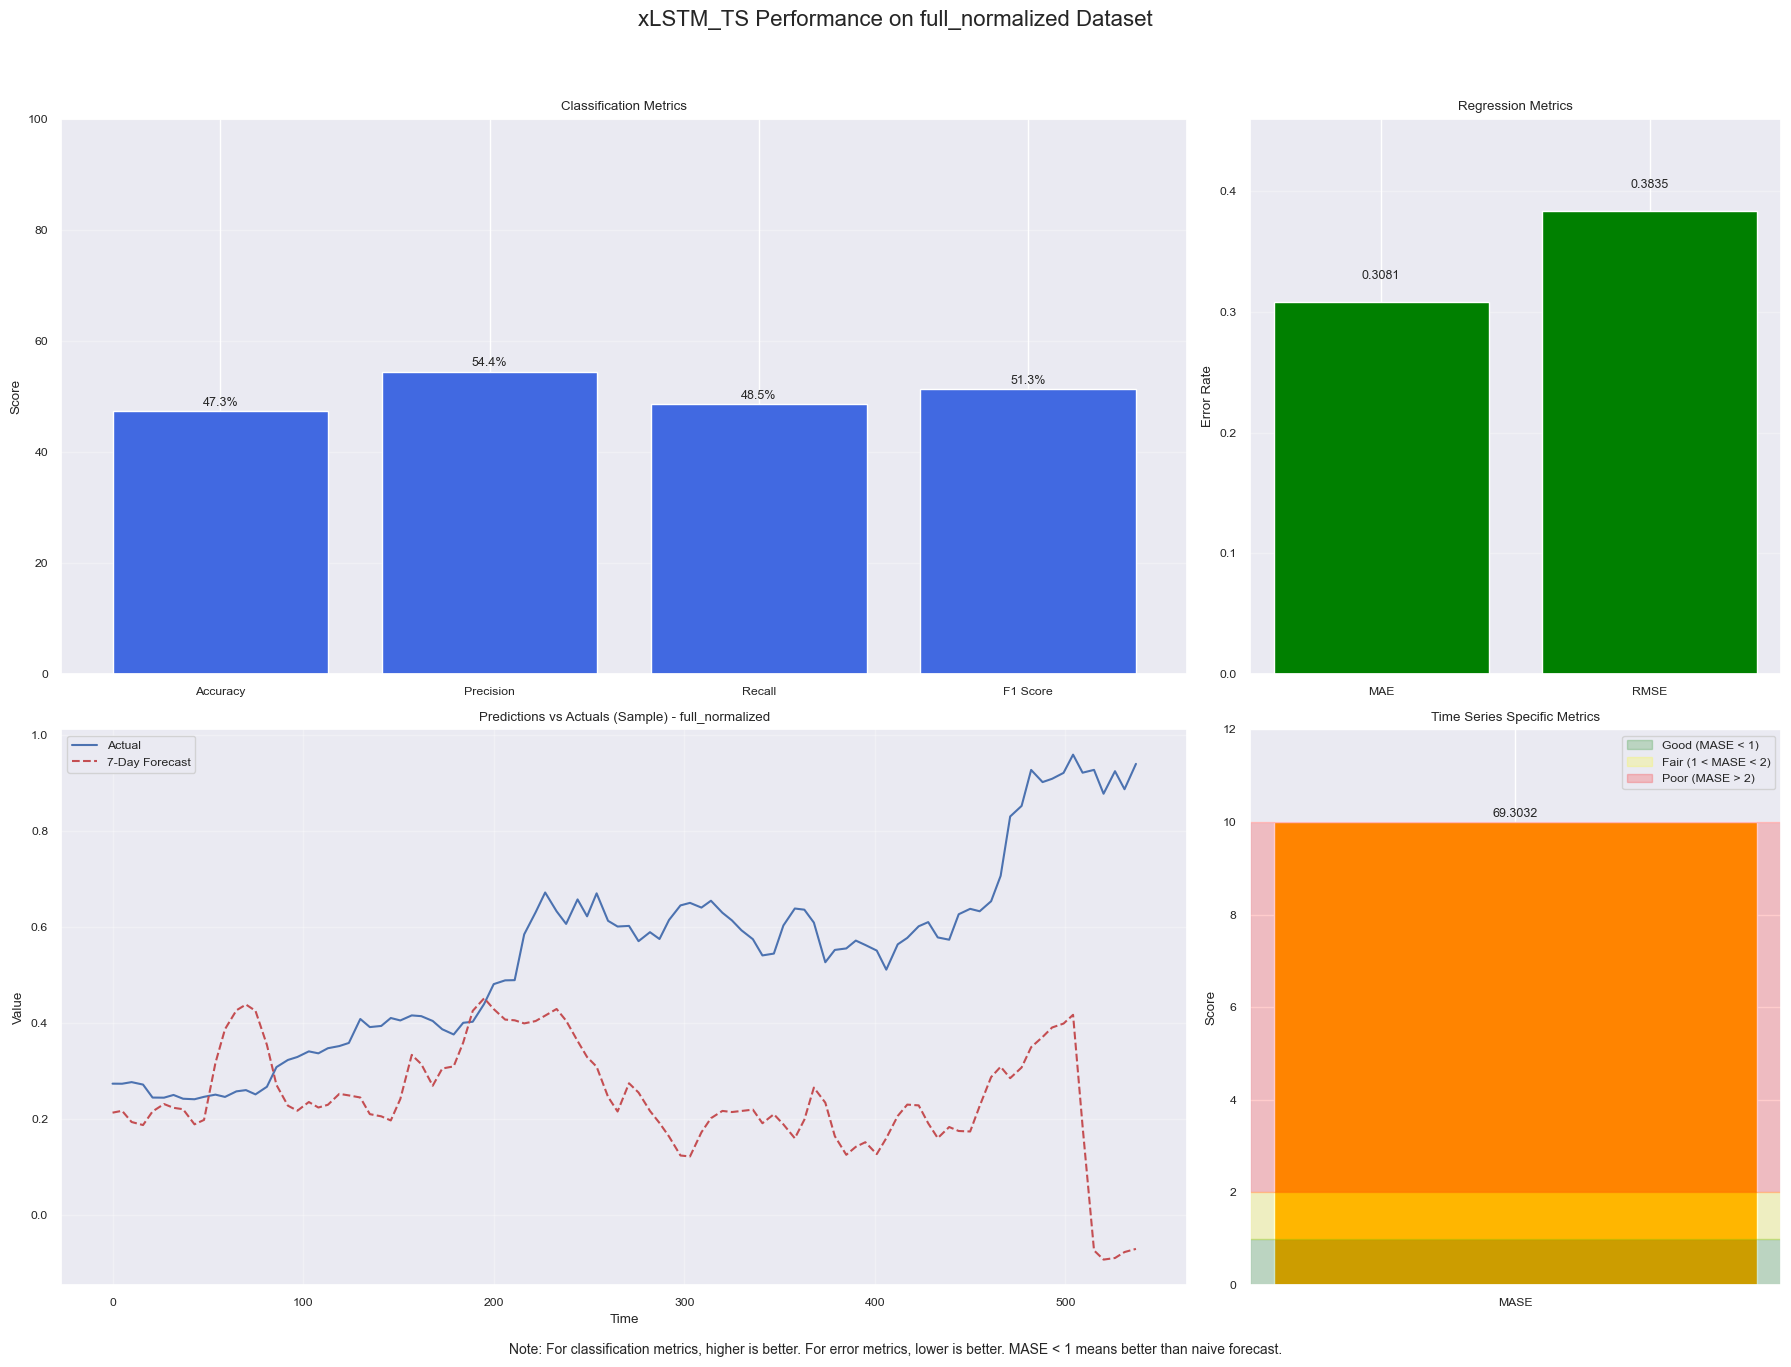


Testing on RANDOM_FOREST_NORMALIZED dataset
------------------------------


Running Xlstm_ts Model:   0%|          | 0/3 [00:00<?, ?it/s]


Initializing xLSTM-TS model training...
Input DataFrame shape: (3685, 5)
Columns: ['Currency US Dollar Index', 'Gold/BTC Ratio', 'S2F Model', 'Onchain Mining Difficulty', 'BTC/USD']
Train shape: (2579, 5)
Feature columns: ['Currency US Dollar Index', 'Gold/BTC Ratio', 'S2F Model', 'Onchain Mining Difficulty']
Feature scaling - Before: [-0.0000, 0.9988]
Feature scaling - After: [0.0000, 0.6312]
Target scaling - Before: [0.0002, 0.6321]
Target scaling - After: [0.0014, 0.0014]
Debug - y_train_original shape: (2579,)

Creating sequences...


Sequence preparation:   0%|          | 0/3 [00:00<?, ?it/s]


Initializing model...

Training model...


Training Progress:   0%|          | 0/322 [00:00<?, ?batch/s]


Generating predictions for xLSTM_TS...
Debug - y_train_original exists with shape (2579,)
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step
Prepared y_train_original with shape (1076,) for metrics

Evaluation Debug Info for xLSTM_TS:
Predictions shape: (538,), Actuals shape: (538,)
Predictions range: [0.2902, 0.7047]
Actuals range: [0.2407, 0.9994]
Binary predictions: 324/537 positive
Binary actuals: 307/537 positive
MASE calculation: MAE=0.166901, Naive MAE=0.004446
RMSSE calculation: RMSE=0.215834, Naive RMSE=0.008733

Plotting forecast for random_forest_normalized:
Actuals shape: (538,)
Actuals range: [0.2407 to 0.9994]


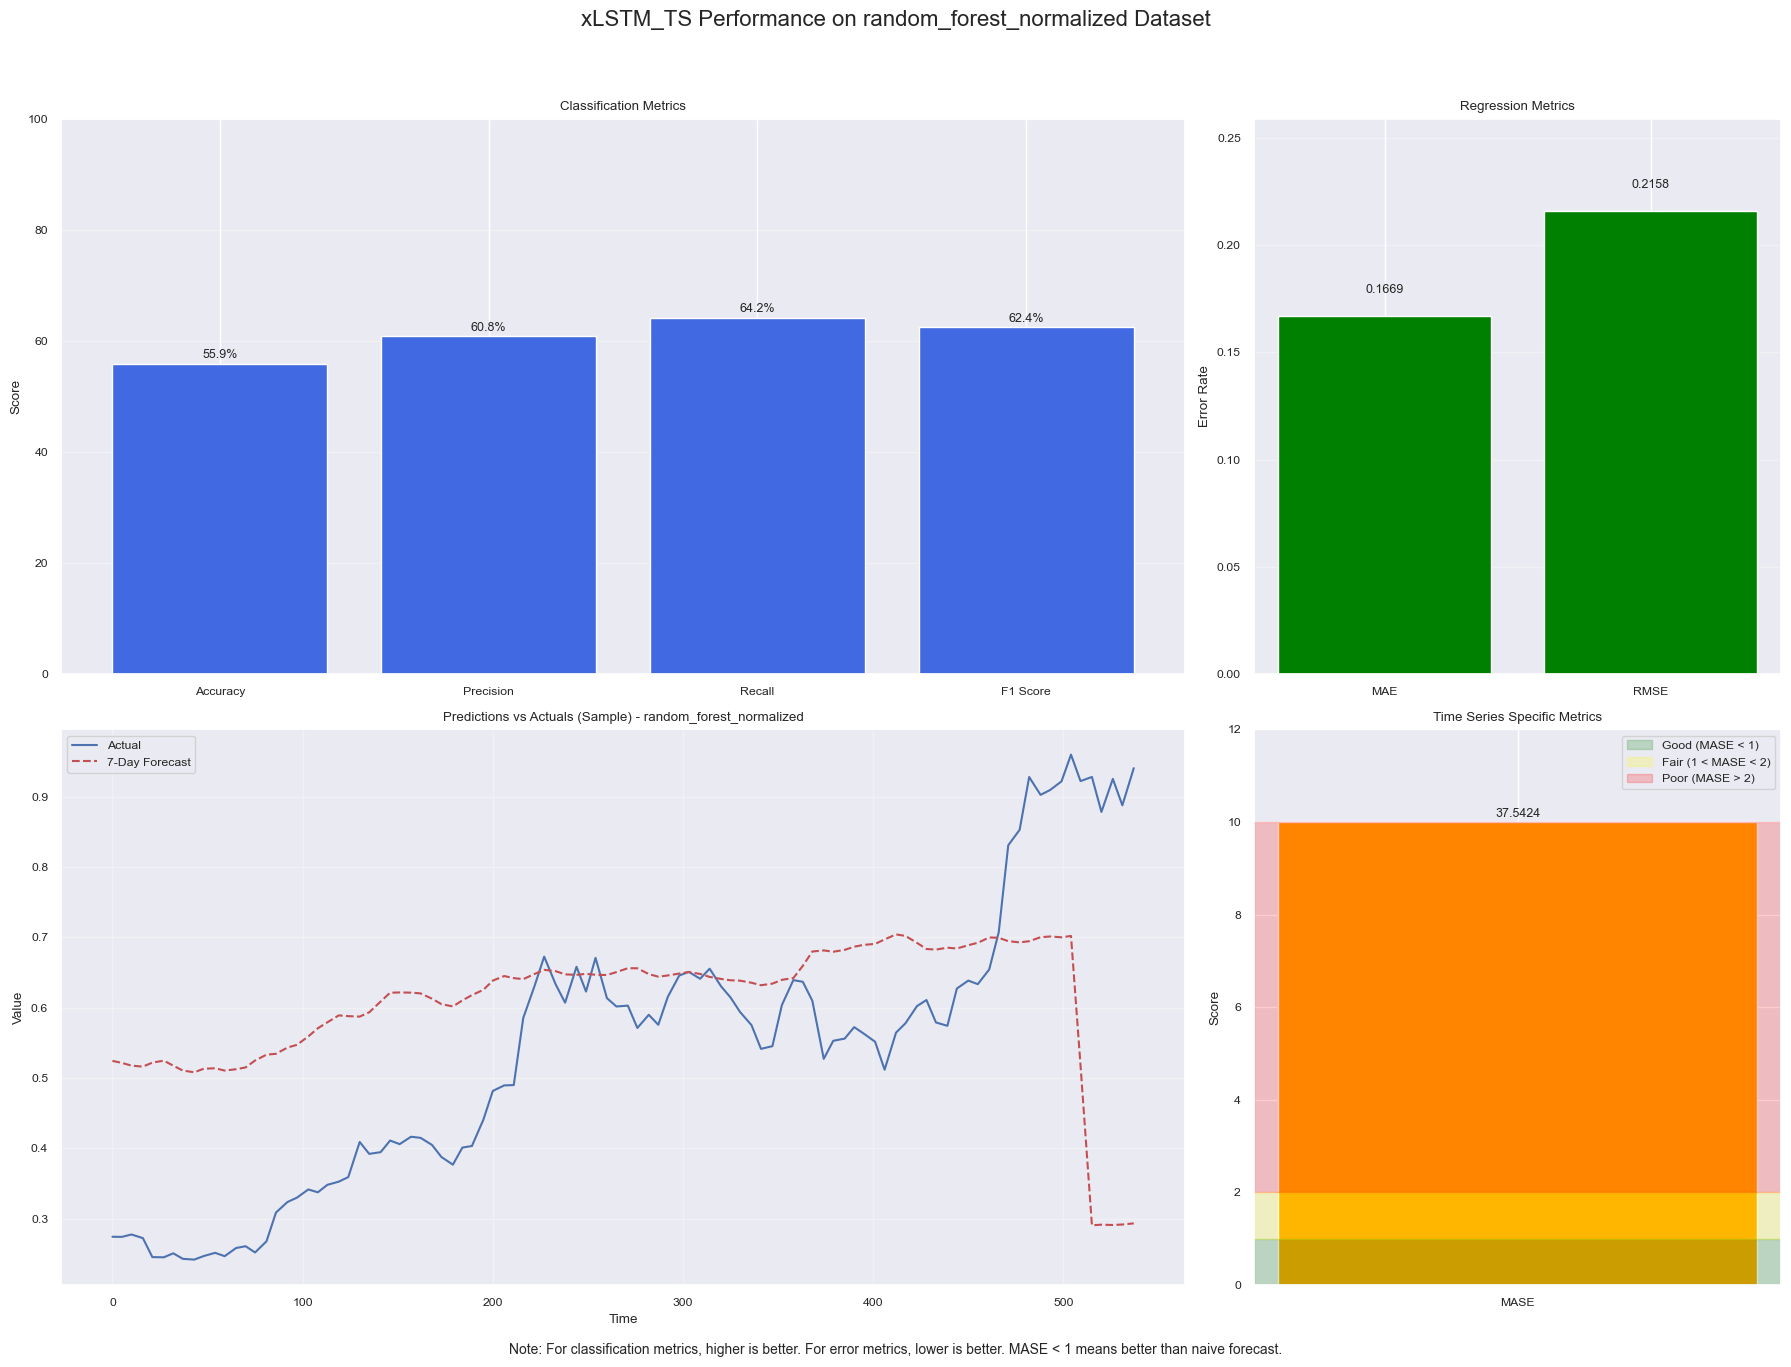


Testing on BORUTA_NORMALIZED dataset
------------------------------


Running Xlstm_ts Model:   0%|          | 0/3 [00:00<?, ?it/s]


Initializing xLSTM-TS model training...
Input DataFrame shape: (3685, 4)
Columns: ['Gold/BTC Ratio', 'S2F Model', 'Onchain Mining Difficulty', 'BTC/USD']
Train shape: (2579, 4)
Feature columns: ['Gold/BTC Ratio', 'S2F Model', 'Onchain Mining Difficulty']
Feature scaling - Before: [-0.0000, 0.9988]
Feature scaling - After: [0.0000, 0.6312]
Target scaling - Before: [0.0002, 0.6321]
Target scaling - After: [0.0014, 0.0014]
Debug - y_train_original shape: (2579,)

Creating sequences...


Sequence preparation:   0%|          | 0/3 [00:00<?, ?it/s]


Initializing model...

Training model...


Training Progress:   0%|          | 0/322 [00:00<?, ?batch/s]


Generating predictions for xLSTM_TS...
Debug - y_train_original exists with shape (2579,)
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step
Prepared y_train_original with shape (1076,) for metrics

Evaluation Debug Info for xLSTM_TS:
Predictions shape: (538,), Actuals shape: (538,)
Predictions range: [-0.3511, 0.2202]
Actuals range: [0.2407, 0.9994]
Binary predictions: 143/537 positive
Binary actuals: 307/537 positive
MASE calculation: MAE=0.476619, Naive MAE=0.004446
RMSSE calculation: RMSE=0.562889, Naive RMSE=0.008733

Plotting forecast for boruta_normalized:
Actuals shape: (538,)
Actuals range: [0.2407 to 0.9994]


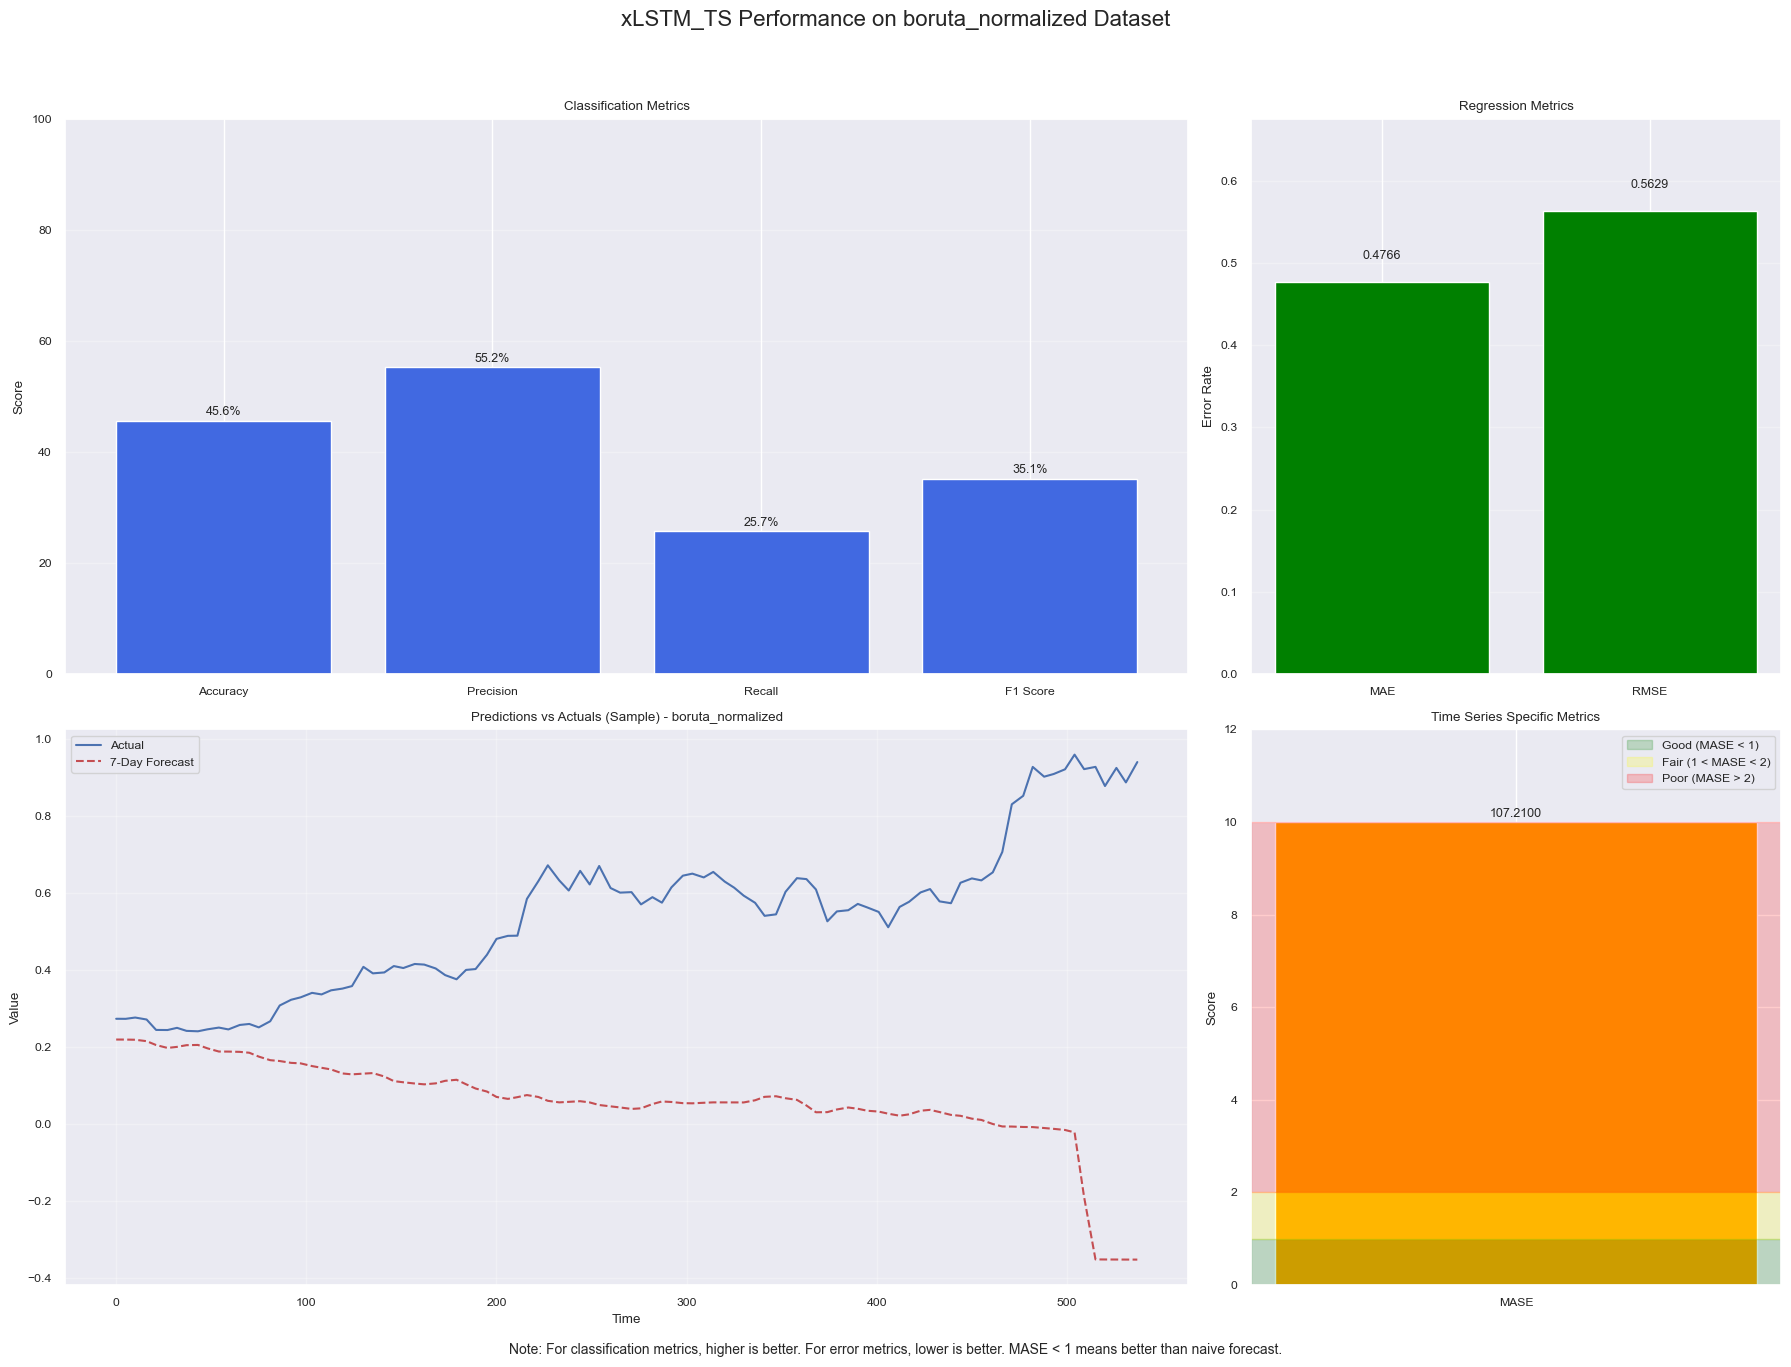


Testing on LASSO_NORMALIZED dataset
------------------------------


Running Xlstm_ts Model:   0%|          | 0/3 [00:00<?, ?it/s]


Initializing xLSTM-TS model training...
Input DataFrame shape: (3685, 9)
Columns: ['Global averaged stocks(USD)', 'Currency US Dollar Index', 'Volatility_CBOE SKEW Index', 'Gold/BTC Ratio', 'BTC Volume', 'S2F Model', 'Onchain Hash Rate (GH/s)', 'Onchain Mining Difficulty', 'BTC/USD']
Train shape: (2579, 9)
Feature columns: ['Global averaged stocks(USD)', 'Currency US Dollar Index', 'Volatility_CBOE SKEW Index', 'Gold/BTC Ratio', 'BTC Volume', 'S2F Model', 'Onchain Hash Rate (GH/s)', 'Onchain Mining Difficulty']
Feature scaling - Before: [-0.0000, 0.9988]
Feature scaling - After: [0.0000, 0.6312]
Target scaling - Before: [0.0002, 0.6321]
Target scaling - After: [0.0014, 0.0014]
Debug - y_train_original shape: (2579,)

Creating sequences...


Sequence preparation:   0%|          | 0/3 [00:00<?, ?it/s]


Initializing model...

Training model...


Training Progress:   0%|          | 0/322 [00:00<?, ?batch/s]


Generating predictions for xLSTM_TS...
Debug - y_train_original exists with shape (2579,)
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step
Prepared y_train_original with shape (1076,) for metrics

Evaluation Debug Info for xLSTM_TS:
Predictions shape: (538,), Actuals shape: (538,)
Predictions range: [-0.4254, 0.1446]
Actuals range: [0.2407, 0.9994]
Binary predictions: 239/537 positive
Binary actuals: 307/537 positive
MASE calculation: MAE=0.605155, Naive MAE=0.004446
RMSSE calculation: RMSE=0.677524, Naive RMSE=0.008733

Plotting forecast for lasso_normalized:
Actuals shape: (538,)
Actuals range: [0.2407 to 0.9994]


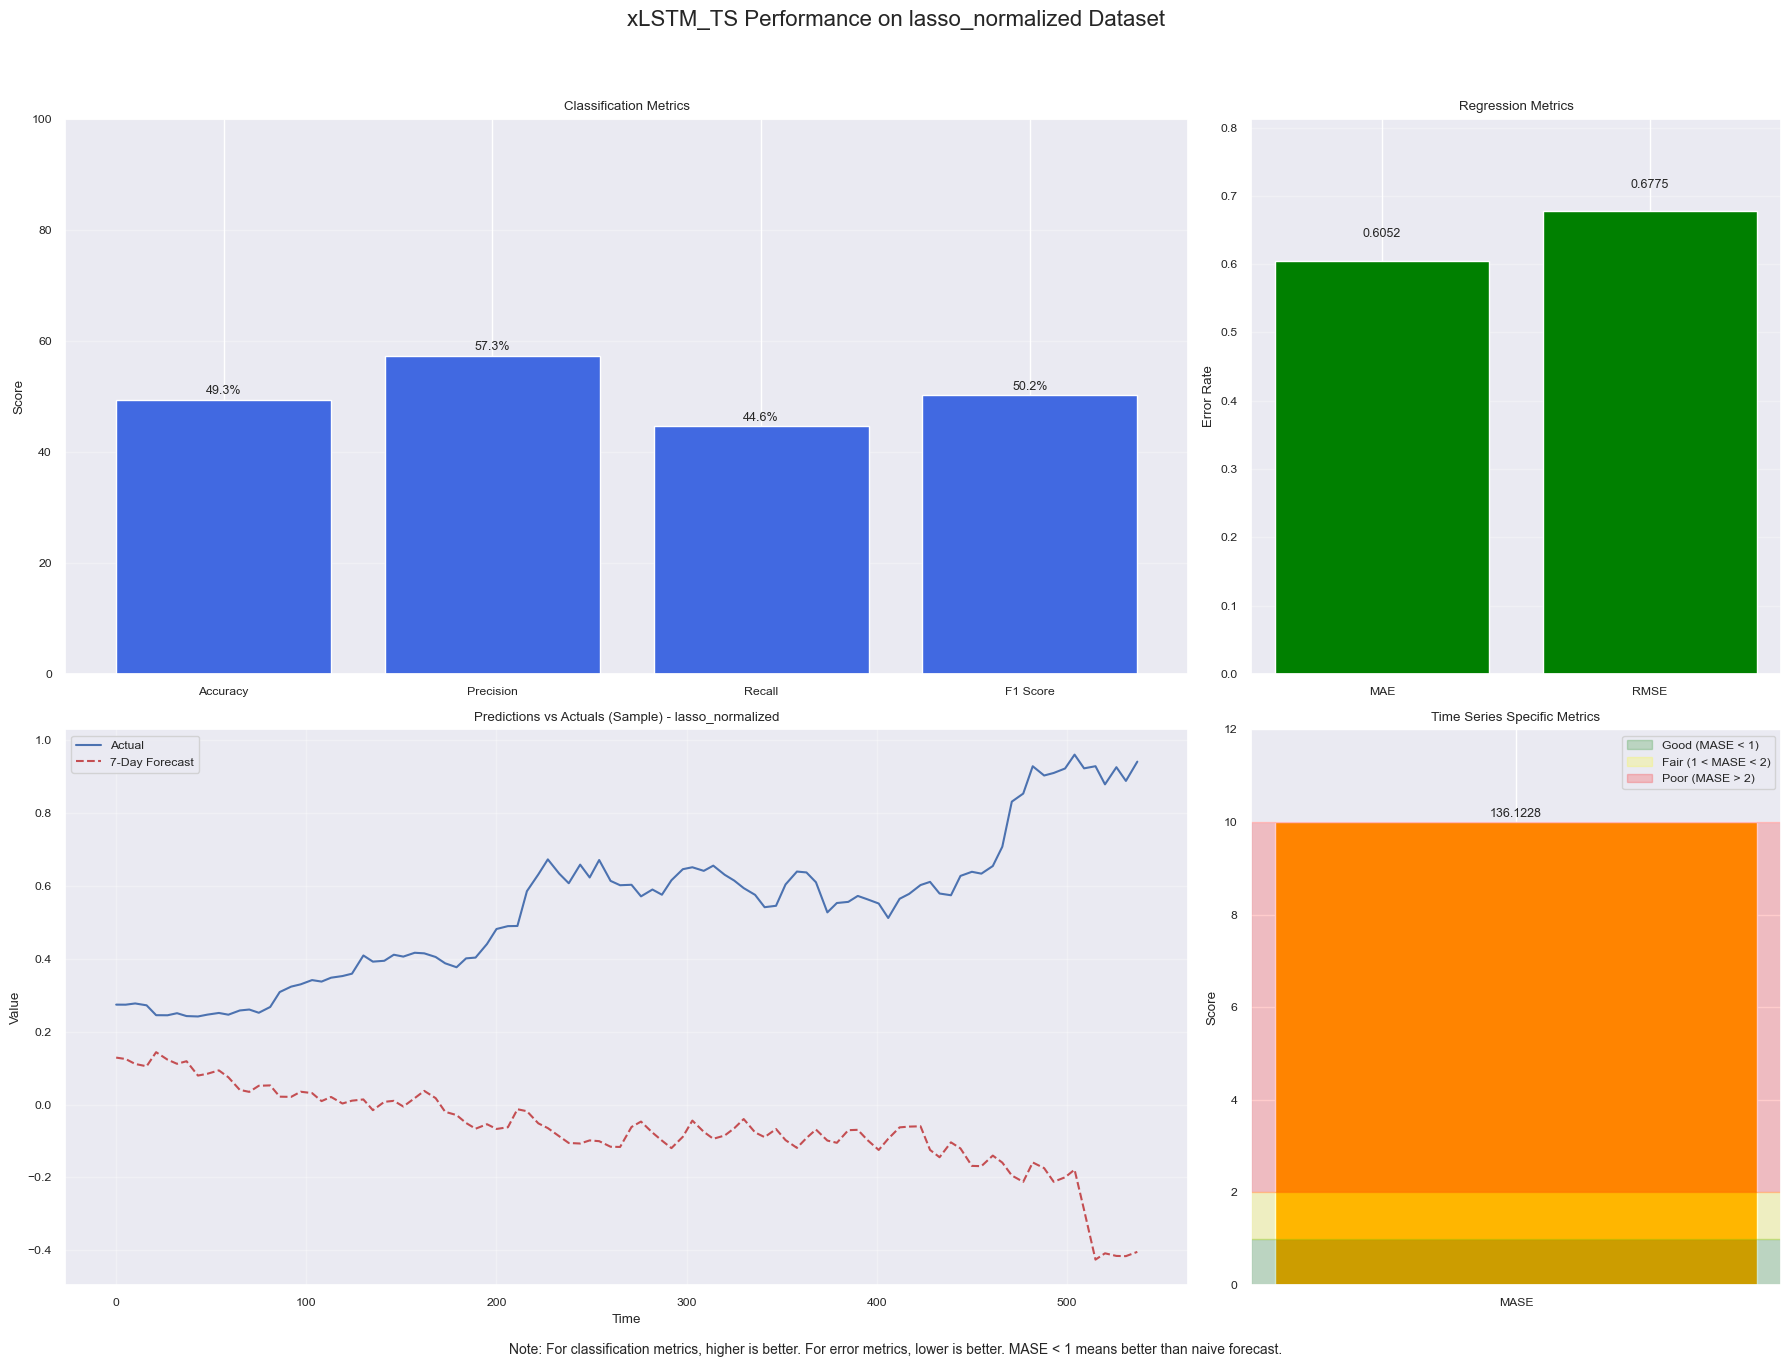


Testing on FULL_DENOISED dataset
------------------------------


Running Xlstm_ts Model:   0%|          | 0/3 [00:00<?, ?it/s]


Initializing xLSTM-TS model training...
Input DataFrame shape: (3685, 17)
Columns: ['Global averaged stocks(USD)', 'Global averaged stocks (volume)', 'Currency US Dollar Index', 'Currency Gold Futures', 'Volatility_CBOE SKEW Index', 'Volatility_CBOE Volatility Index (VIX)', 'Volatility_Crude Oil Volatility Index (OVX)', 'Gold/BTC Ratio', 'BTC/USD', 'BTC Volume', 'S2F Model', 'Onchain Active Addresses', 'Onchain Transaction Count', 'Onchain Hash Rate (GH/s)', 'Onchain Mining Difficulty', 'Onchain Transaction Fees (BTC)', 'Onchain Median Confirmation Time (min)']
Train shape: (2579, 17)
Feature columns: ['Global averaged stocks(USD)', 'Global averaged stocks (volume)', 'Currency US Dollar Index', 'Currency Gold Futures', 'Volatility_CBOE SKEW Index', 'Volatility_CBOE Volatility Index (VIX)', 'Volatility_Crude Oil Volatility Index (OVX)', 'Gold/BTC Ratio', 'BTC Volume', 'S2F Model', 'Onchain Active Addresses', 'Onchain Transaction Count', 'Onchain Hash Rate (GH/s)', 'Onchain Mining Diffi

Sequence preparation:   0%|          | 0/3 [00:00<?, ?it/s]


Initializing model...

Training model...


Training Progress:   0%|          | 0/322 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [ ]:
def run_evaluations_on_all_feature_sets(output_dir): # (Claude, 2025)
    csvdir = output_dir / "charts" / "evaluation_metrics" / "csv"
    csvdir.mkdir(parents=True, exist_ok=True)
    # First load all datasets
    datasets = {
        'full_normalized': pd.read_csv(output_dir / "2015-2025_dataset_denoised.csv", index_col=0, parse_dates=True),
        'random_forest_normalized': pd.read_csv(output_dir / "2015-2025_dataset_selected_features_random_forest_denoised.csv", index_col=0, parse_dates=True),
        'boruta_normalized': pd.read_csv(output_dir / "2015-2025_dataset_selected_features_boruta_denoised.csv", index_col=0, parse_dates=True),
        'lasso_normalized': pd.read_csv(output_dir / "2015-2025_dataset_selected_features_lasso_denoised.csv", index_col=0, parse_dates=True),
        # adding additional non-denoised datasets for testing completeness.
        'full_denoised': pd.read_csv(output_dir / "2015-2025_dataset_normalized.csv", index_col=0, parse_dates=True),
        'random_forest_denoised': pd.read_csv(output_dir / "2015-2025_dataset_selected_features_random_forest_normalized.csv", index_col=0, parse_dates=True),
        'boruta_denoised': pd.read_csv(output_dir / "2015-2025_dataset_selected_features_boruta_normalized.csv", index_col=0, parse_dates=True),
        'lasso_denoised': pd.read_csv(output_dir / "2015-2025_dataset_selected_features_lasso_normalized.csv", index_col=0, parse_dates=True)
    }
    
    # Dictionary to store all results
    all_results = {}
    
    # Run each model type
    for model_type in ['xLSTM_TS', 'random_forest']:
        print(f"\nEVALUATING {model_type.upper()} MODEL")
        print("=" * 50)
        model_results = {}
        
        # Test each feature set
        for dataset_name, df in datasets.items():
            print(f"\nTesting on {dataset_name.upper()} dataset")
            print("-" * 30)
            
            # Run the model evaluation with the current dataset
            metrics = run_model_evaluation(output_dir, dataset_name, model_type, df)
            model_results[dataset_name] = metrics
            
            # Save individual results
            pd.DataFrame([metrics]).to_csv(output_dir / "charts" / "evaluation_metrics" / "csv" / f'{model_type}_model_metrics_{dataset_name}.csv', index=False)
        
        # Store results for this model type
        all_results[model_type] = model_results
        
        # Create comparison DataFrame for this model
        comparison_df = pd.DataFrame(model_results).T
        comparison_df.to_csv(output_dir / "charts" / "evaluation_metrics" / "csv" /  f'{model_type}_model_metrics_comparison.csv')
        plot_dataset_comparison(comparison_df, model_type, output_dir)
        
        # Print comparison summary
        print(f"\n{model_type.upper()} Model Performance Comparison:")
        print("=" * 50)
        
        for dataset_name, metrics in model_results.items():
            print(f"\n{dataset_name.upper()} Dataset:")
            print(f"Accuracy: {metrics['Accuracy']*100:.2f}%")
            print(f"F1 Score: {metrics['F1 Score']*100:.2f}%")
            print(f"MAE: {metrics['MAE']*100:.2f}%")
            print(f"RMSE: {metrics['RMSE']*100:.2f}%")
            print(f"MASE: {metrics['MASE']:.2f}")
    
    # Save overall comparison
    overall_comparison = pd.DataFrame({
        f"{model}_{dataset}": metrics 
        for model, model_results in all_results.items() 
        for dataset, metrics in model_results.items()
    })
    overall_comparison.to_csv(output_dir / "charts" / "evaluation_metrics" / "csv" / f'{model_type}_model_metrics_comparison.csv')
    
    return all_results

# Modified run_model_evaluation to accept the dataset parameter
def run_model_evaluation(output_dir, dataset_name, model_type, df):
    with tqdm(total=3, desc=f"Running {model_type.capitalize()} Model") as pbar:
        
        # Step 1: Train the model
        if model_type == 'xLSTM_TS':
            model_results = use_xLSTM_TS_model(df)
        elif model_type == 'random_forest':
            model_results = use_random_forest_model(df)
        else:
            raise ValueError(f"Unknown model type: {model_type}")
        
        pbar.update(1)
        
        # Step 2: Get predictions using the enhanced function
        predictions, actuals, y_train, multi_day_forecast = get_predictions(model_results, model_type)
        pbar.update(1)
                
        # Step 3: Calculate and display metrics for day 1 predictions
        metrics = evaluate_model(predictions, actuals, y_train, model_type)
        #print_metrics(metrics, model_type)
        
        # Plot metrics - UPDATED to pass multi_day_forecast
        plot_metrics(metrics, model_type=model_type, dataset_name=dataset_name, predictions=predictions, actuals=actuals, output_dir=output_dir,multi_day_forecast=multi_day_forecast)  # Add this parameter
       
        pbar.update(1)
        
        # Save metrics
        pd.DataFrame([metrics]).to_csv(output_dir  / "charts" / "evaluation_metrics" / "csv" / f'{model_type}_model_metrics.csv', index=False)
    
    return metrics

# run all the training and evaluations
all_results = run_evaluations_on_all_feature_sets(output_dir)
# make sure we have a valid data frame.
df = pd.read_csv(output_dir / "2015-2025_dataset_denoised.csv", index_col=0, parse_dates=True)
# run the tunning on random forest and run a comparison graph on it after.
results = run_random_forest_comparison(df, n_iterations=25) # 25